## Import libraries

In [65]:
import os
import re
import json
import joblib
from joblib import Parallel, delayed
import glob
import numpy as np
import pandas as pd
import torch
import time
from collections import defaultdict
from IPython.display import display, Markdown

# Feature Engineering & Modeling
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_percentage_error as mape
# from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNRegressor
from tabpfn import TabPFNRegressor
import plotly.express as px
from lightgbm import LGBMRegressor

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

## Load Data

In [66]:
# Define path to training and test data
DATA_FILE =  "dataset/train.csv" 
TEST_FILE =  "dataset/test.csv" 

# 1. Load the training hackathon dataset from the CSV file
df_train = pd.read_csv(DATA_FILE)

df_test = pd.read_csv(TEST_FILE)



# 2. Define Features (X) and Targets (y)
# Features are the component columns
feature_cols = df_train.loc[:, "Component1_fraction":"Component5_Property10"].columns
# Targets are the blend property columns
target_cols = df_train.loc[:, "BlendProperty1":"BlendProperty10"].columns

X_train = df_train[feature_cols]
y_train = df_train[target_cols]

X_test = df_test[feature_cols]

### EDA


 Target Variable Correlation Analysis


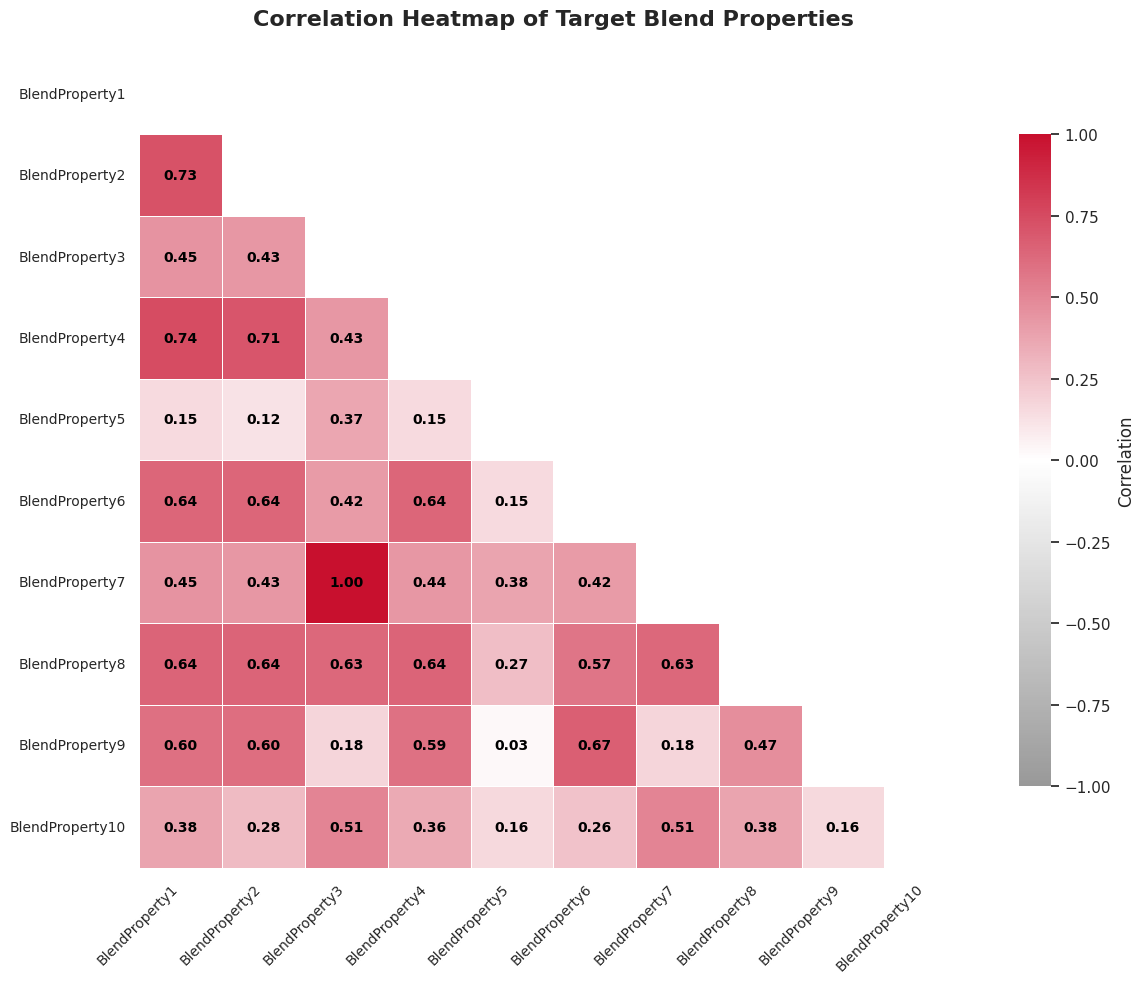

In [75]:
print(f"\n{'=' * 80}\n Target Variable Correlation Analysis\n{'=' * 80}")

sns.set_theme(style="white")
corr = df_train[[f'BlendProperty{i}' for i in range(1, 11)]].corr()

nn_colors = LinearSegmentedColormap.from_list("nn_red", ["#999999", "#ffffff", "#C8102E"])

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=np.triu(np.ones_like(corr, bool)),
    annot=True,
    fmt=".2f",
    cmap=nn_colors,
    vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    annot_kws={"size": 10, "weight": "bold", "color": "black"}
)
plt.title("Correlation Heatmap of Target Blend Properties", fontsize=16, pad=20, fontweight="bold")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig("plots/correlation_heatmap.png", dpi=300)
plt.show()


>EDA shows that the strength of correlations varies wildly between different pairs of targets. 
This complexity justifies our core strategy of building a specialized model for each target. Each property is unique, so each one deserves its own custom-engineered and selected feature set to maximize its individual prediction accuracy.

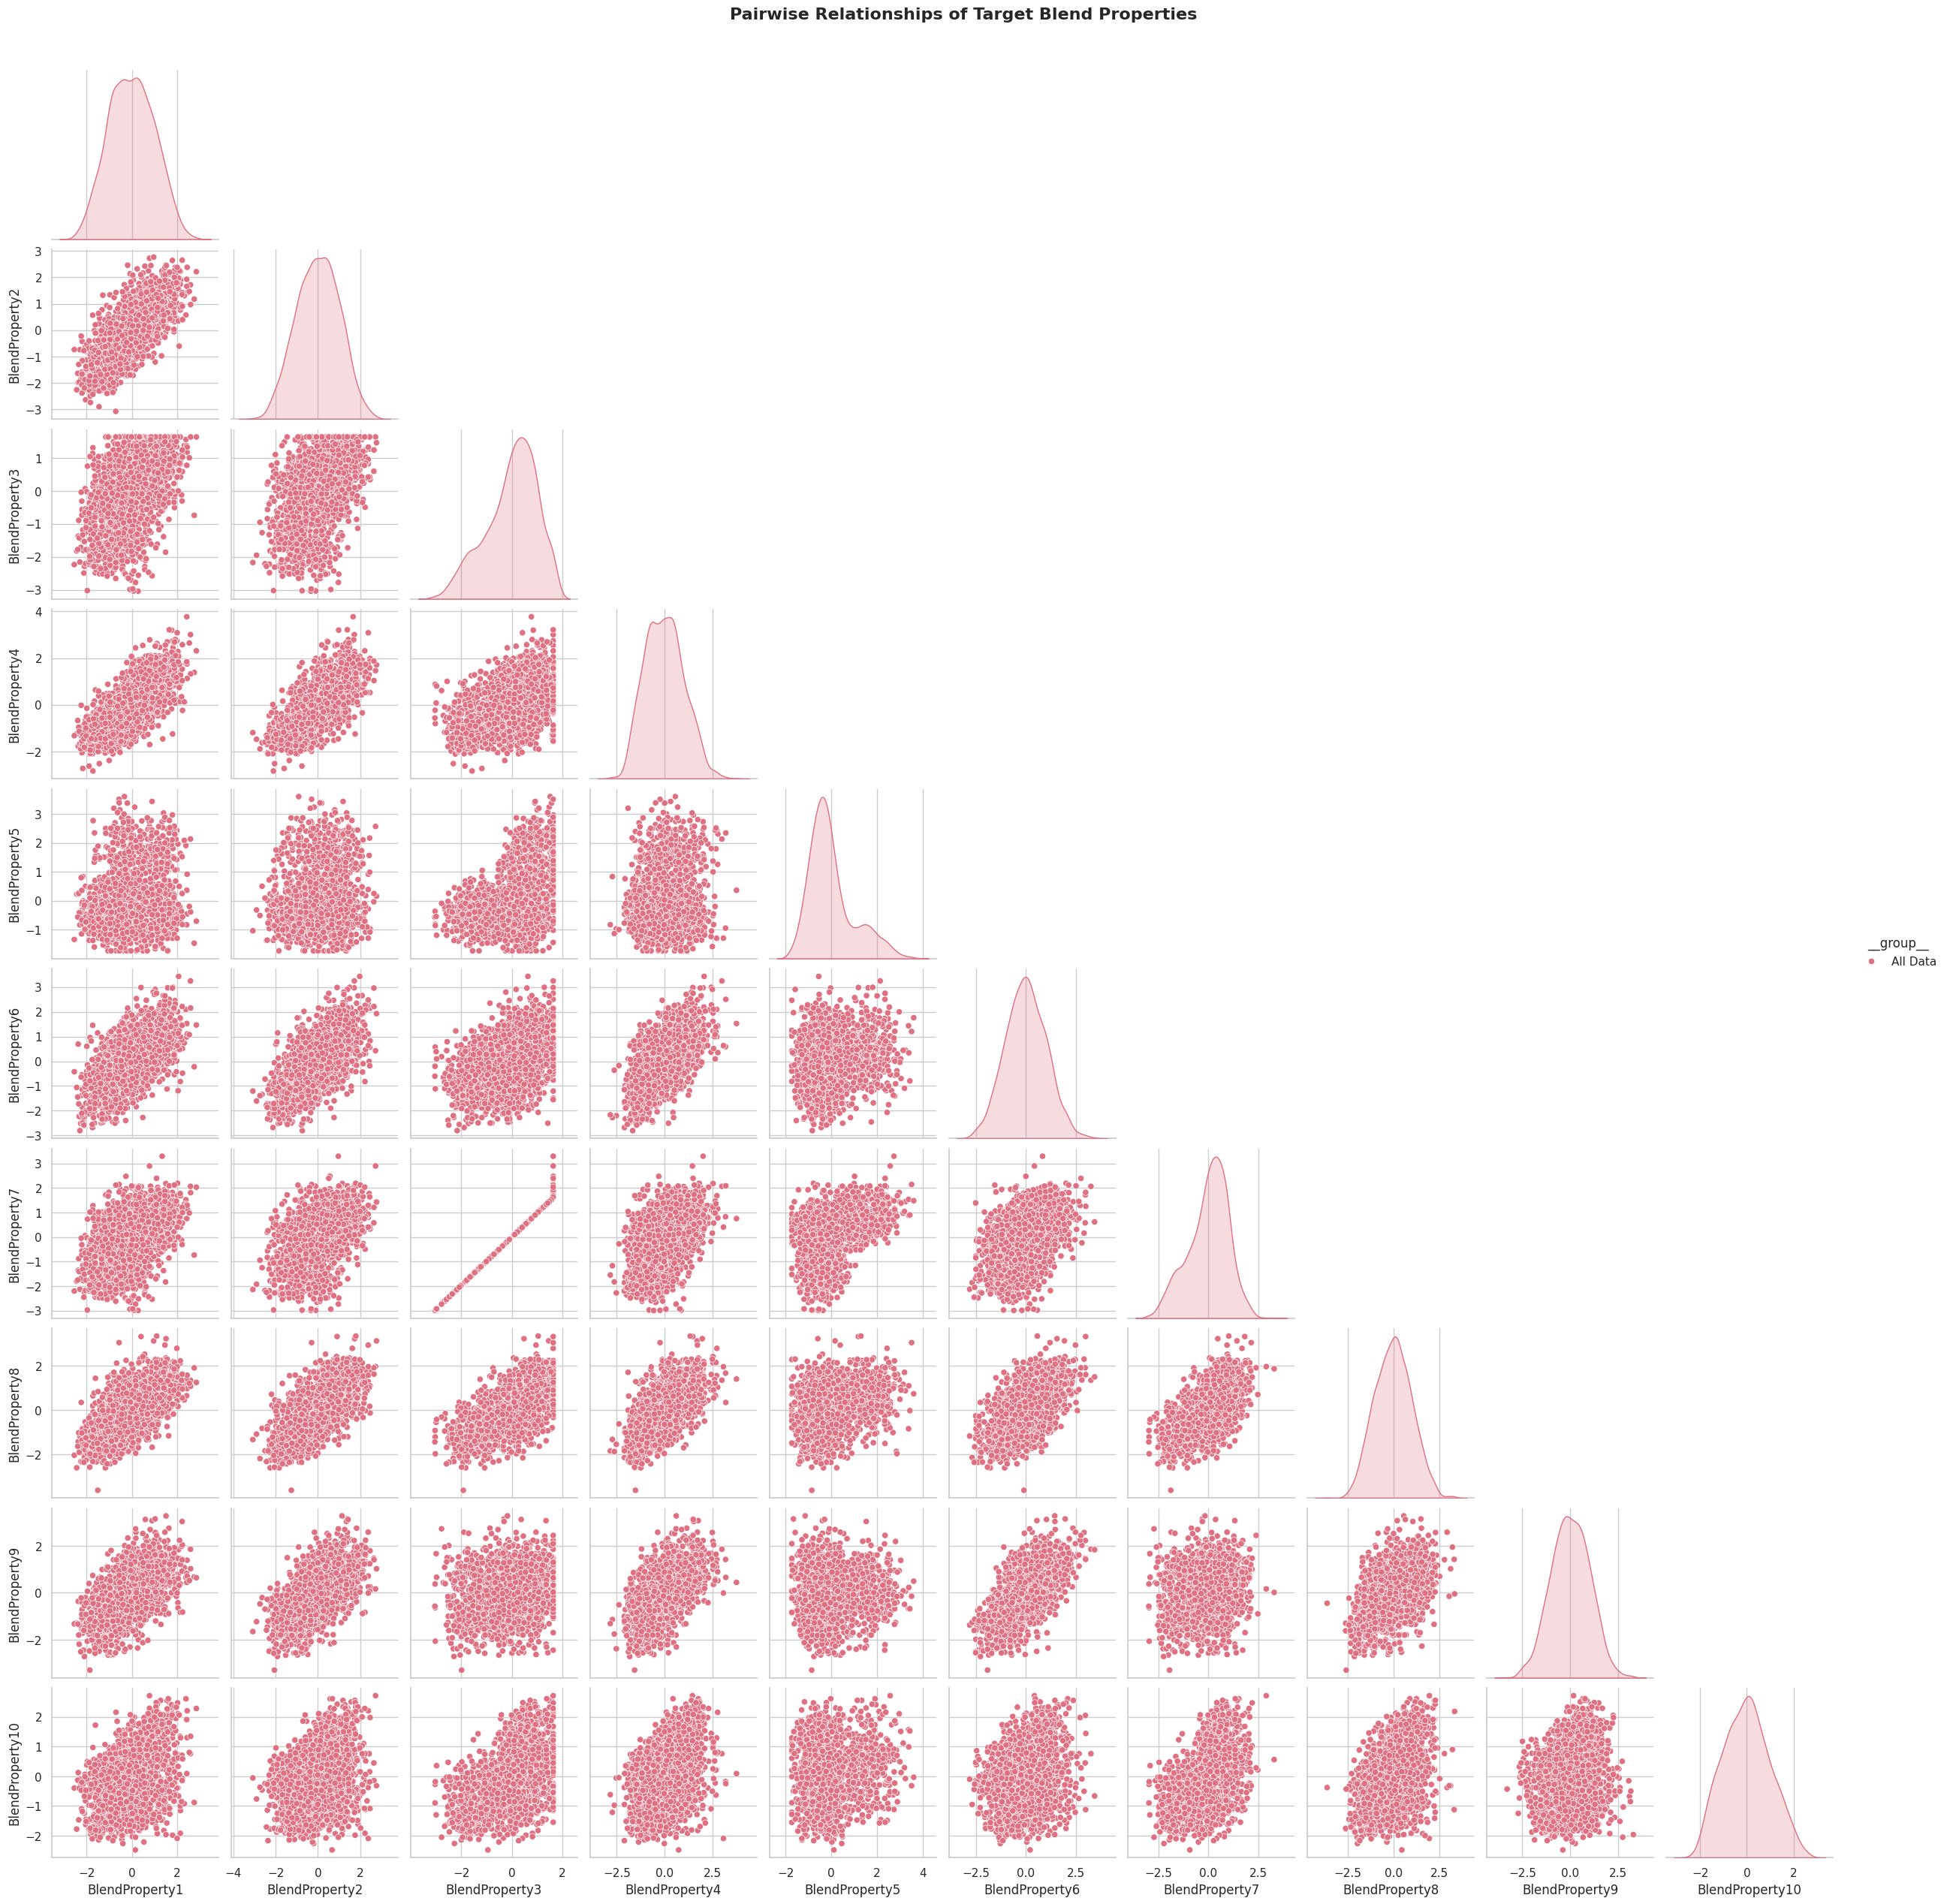

In [76]:
sns.set_theme(style="whitegrid")
df_targets_ = df_targets_.copy()
df_targets_["__group__"] = "All Data"
nn_palette = [nn_colors(0.8)]  # pick the red tone from your gradient
pairplot_fig = sns.pairplot(
    df_targets_,
    diag_kind="kde",
    corner=True,
    hue="__group__",
    palette=nn_palette
)
pairplot_fig.fig.suptitle(
    "Pairwise Relationships of Target Blend Properties",
    fontsize=16, fontweight="bold",
    y=1.02
)
pairplot_fig.fig.savefig("plots/pairplot_targets.png", dpi=300)
plt.show()

# Feature Engineering Pipeline

## Feature Engineering with Autofeat

In [4]:
from autofeat import AutoFeatRegressor

target_cols = y_train.columns

# Dictionaries to store the results for each target
afreg_objects = {}
X_train_transformed = {}
X_test_transformed = {}

for tgt in target_cols:
    print(f"🔧 Running enhanced AutoFeat for target: {tgt}")
    
    # Create a AutoFeat instance
    af = AutoFeatRegressor(
        verbose=1,                 # Show progress updates
        feateng_steps=2,           # Complex feature combinations order 2
        n_jobs=-3,
        featsel_runs=1,
        # Customize feature transformations:
        transformations=("exp", "log", "abs", "sqrt", "^2", "^3", "1/"), 
    )
    
    # Fit on training data and transform both sets
    Xtr = af.fit_transform(X_train, y_train[tgt])
    Xte = af.transform(X_test)

    # Store the results
    afreg_objects[tgt] = af
    X_train_transformed[tgt] = Xtr
    X_test_transformed[tgt] = Xte
    
    print(f"  ➜ Generated {Xtr.shape[1]} powerful features for {tgt}")

/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔧 Running enhanced AutoFeat for target: BlendProperty1
[featsel] Scaling data...done.      53301 feature tuples combined


/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


[AutoFeat]    47/   48 new features

/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  ➜ Generated 103 powerful features for BlendProperty1
🔧 Running enhanced AutoFeat for target: BlendProperty2
[featsel] Scaling data...done.      53301 feature tuples combined


/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


[AutoFeat]    54/   55 new features

/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  ➜ Generated 110 powerful features for BlendProperty2
🔧 Running enhanced AutoFeat for target: BlendProperty3
[featsel] Scaling data...done.      53301 feature tuples combined


/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


[AutoFeat]    31/   42 new features

/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  ➜ Generated 97 powerful features for BlendProperty3
🔧 Running enhanced AutoFeat for target: BlendProperty4
[featsel] Scaling data...done.      53301 feature tuples combined


/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


  ➜ Generated 103 powerful features for BlendProperty4
🔧 Running enhanced AutoFeat for target: BlendProperty5


/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[featsel] Scaling data...done.      53301 feature tuples combined


/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


[AutoFeat]    40/   41 new features

/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  ➜ Generated 96 powerful features for BlendProperty5
🔧 Running enhanced AutoFeat for target: BlendProperty6
[featsel] Scaling data...done.      53301 feature tuples combined


/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


[AutoFeat]    39/   40 new features

/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  ➜ Generated 95 powerful features for BlendProperty6
🔧 Running enhanced AutoFeat for target: BlendProperty7
[featsel] Scaling data...done.      53301 feature tuples combined


/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


[AutoFeat]    44/   45 new features

/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  ➜ Generated 100 powerful features for BlendProperty7
🔧 Running enhanced AutoFeat for target: BlendProperty8
[featsel] Scaling data...done.      53301 feature tuples combined


/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


[AutoFeat]    88/   89 new features

/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  ➜ Generated 144 powerful features for BlendProperty8
🔧 Running enhanced AutoFeat for target: BlendProperty9
[featsel] Scaling data...done.      53301 feature tuples combined


/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


[AutoFeat]    61/   62 new features

/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  ➜ Generated 117 powerful features for BlendProperty9
🔧 Running enhanced AutoFeat for target: BlendProperty10
[featsel] Scaling data...done.      53301 feature tuples combined


/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


  ➜ Generated 97 powerful features for BlendProperty10


/home/dara/miniconda3/envs/rapids-hackathon/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [5]:
TRAIN_OUT_DIR = "./X_train"
TEST_OUT_DIR  = "./X_test"

os.makedirs(TRAIN_OUT_DIR, exist_ok=True)
os.makedirs(TEST_OUT_DIR,  exist_ok=True)

for tgt in target_cols:
    # build descriptive filenames
    train_fp = os.path.join(TRAIN_OUT_DIR, f"X_train_{tgt}.csv")
    test_fp  = os.path.join(TEST_OUT_DIR,  f"X_test_{tgt}.csv")

    # write to disk
    X_train_transformed[tgt].to_csv(train_fp, index=False)
    X_test_transformed[tgt].to_csv(test_fp,  index=False)

    print(f"📝 saved  {train_fp}")
    print(f"📝 saved  {test_fp}")

📝 saved  ./X_train/X_train_BlendProperty1.csv
📝 saved  ./X_test/X_test_BlendProperty1.csv
📝 saved  ./X_train/X_train_BlendProperty2.csv
📝 saved  ./X_test/X_test_BlendProperty2.csv
📝 saved  ./X_train/X_train_BlendProperty3.csv
📝 saved  ./X_test/X_test_BlendProperty3.csv
📝 saved  ./X_train/X_train_BlendProperty4.csv
📝 saved  ./X_test/X_test_BlendProperty4.csv
📝 saved  ./X_train/X_train_BlendProperty5.csv
📝 saved  ./X_test/X_test_BlendProperty5.csv
📝 saved  ./X_train/X_train_BlendProperty6.csv
📝 saved  ./X_test/X_test_BlendProperty6.csv
📝 saved  ./X_train/X_train_BlendProperty7.csv
📝 saved  ./X_test/X_test_BlendProperty7.csv
📝 saved  ./X_train/X_train_BlendProperty8.csv
📝 saved  ./X_test/X_test_BlendProperty8.csv
📝 saved  ./X_train/X_train_BlendProperty9.csv
📝 saved  ./X_test/X_test_BlendProperty9.csv
📝 saved  ./X_train/X_train_BlendProperty10.csv
📝 saved  ./X_test/X_test_BlendProperty10.csv


## Reload Engineered Features

In [69]:
TRAIN_DIR = "./X_train"
TEST_DIR  = "./X_test"

# regex to capture the target name in the filename
pattern = re.compile(r"X_(train|test)_(BlendProperty\d+)\.csv", re.I)

X_train_loaded, X_test_loaded = {}, {}

# ---------- load training CSVs ---------------------------------------
for fp in glob.glob(os.path.join(TRAIN_DIR, "X_train_*.csv")):
    m = pattern.search(os.path.basename(fp))
    if m:
        tgt = m.group(2)                      # for example "BlendProperty3"
        X_train_loaded[tgt] = pd.read_csv(fp)
        print(f"📥 loaded {fp}  →  {X_train_loaded[tgt].shape}")

# ---------- load test CSVs -------------------------------------------
for fp in glob.glob(os.path.join(TEST_DIR, "X_test_*.csv")):
    m = pattern.search(os.path.basename(fp))
    if m:
        tgt = m.group(2)
        X_test_loaded[tgt] = pd.read_csv(fp)
        print(f"📥 loaded {fp}  →  {X_test_loaded[tgt].shape}")

# ---------- sanity check ---------------------------------------------
print("\nTargets found:", sorted(X_train_loaded.keys()))

📥 loaded ./X_train/X_train_BlendProperty3.csv  →  (2000, 97)
📥 loaded ./X_train/X_train_BlendProperty2.csv  →  (2000, 110)
📥 loaded ./X_train/X_train_BlendProperty7.csv  →  (2000, 100)
📥 loaded ./X_train/X_train_BlendProperty5.csv  →  (2000, 96)
📥 loaded ./X_train/X_train_BlendProperty8.csv  →  (2000, 144)
📥 loaded ./X_train/X_train_BlendProperty4.csv  →  (2000, 103)
📥 loaded ./X_train/X_train_BlendProperty10.csv  →  (2000, 97)
📥 loaded ./X_train/X_train_BlendProperty6.csv  →  (2000, 95)
📥 loaded ./X_train/X_train_BlendProperty1.csv  →  (2000, 103)
📥 loaded ./X_train/X_train_BlendProperty9.csv  →  (2000, 117)
📥 loaded ./X_test/X_test_BlendProperty3.csv  →  (500, 97)
📥 loaded ./X_test/X_test_BlendProperty5.csv  →  (500, 96)
📥 loaded ./X_test/X_test_BlendProperty7.csv  →  (500, 100)
📥 loaded ./X_test/X_test_BlendProperty8.csv  →  (500, 144)
📥 loaded ./X_test/X_test_BlendProperty1.csv  →  (500, 103)
📥 loaded ./X_test/X_test_BlendProperty6.csv  →  (500, 95)
📥 loaded ./X_test/X_test_BlendPr

In [70]:
for tgt, df in X_train_loaded.items():
    print(tgt, df.shape)

BlendProperty3 (2000, 97)
BlendProperty2 (2000, 110)
BlendProperty7 (2000, 100)
BlendProperty5 (2000, 96)
BlendProperty8 (2000, 144)
BlendProperty4 (2000, 103)
BlendProperty10 (2000, 97)
BlendProperty6 (2000, 95)
BlendProperty1 (2000, 103)
BlendProperty9 (2000, 117)


In [71]:
X_train_loaded['BlendProperty7'].head()

Component1_fraction  Component2_fraction  Component3_fraction  \
0                 0.21                 0.00                 0.42   
1                 0.02                 0.33                 0.19   
2                 0.08                 0.08                 0.18   
3                 0.25                 0.42                 0.00   
4                 0.26                 0.16                 0.08   

   Component4_fraction  Component5_fraction  Component1_Property1  \
0                 0.25                 0.12             -0.021782   
1                 0.46                 0.00             -0.224339   
2                 0.50                 0.16              0.457763   
3                 0.07                 0.26             -0.577734   
4                 0.50                 0.00              0.120415   

   Component2_Property1  Component3_Property1  Component4_Property1  \
0              1.981251              0.020036              0.140315   
1              1.148036             -1.107840              0.149533   
2              0.242591             -0.922492              0.908213   
3             -0.930826              0.815284              0.447514   
4              0.666268             -0.626934              2.725357   

   Component5_Property1  ...  Component1_Property2**2*Component1_Property7**2  \
0              1.032029  ...                                         0.392421   
1             -0.354000  ...                                         1.677207   
2              0.972003  ...                                         0.000025   
3              0.455717  ...                                         0.100405   
4              0.392259  ...                                         0.005725   

   Component1_Property1**3*Component3_Property7**3  \
0                                         0.000024   
1                                        -0.000173   
2                                        -0.462655   
3                                         0.048627   
4                                        -0.000152   

   Component3_Property10**2*Component3_Property7**3  \
0                                         -0.226180   
1                                          0.000284   
2                                         -0.001151   
3                                         -0.003568   
4                                         -0.019122   

   Component2_fraction**3*exp(Component1_Property7)  \
0                                          0.000000   
1                                          0.010774   
2                                          0.000523   
3                                          0.043215   
4                                          0.002264   

   exp(Component1_fraction)*exp(Component2_fraction)  \
0                                           1.233678   
1                                           1.419068   
2                                           1.173511   
3                                           1.954237   
4                                           1.521962   

   exp(Component4_fraction)*exp(Component5_fraction)  \
0                                           1.447735   
1                                           1.584074   
2                                           1.934792   
3                                           1.390968   
4                                           1.648721   

   Component4_Property7**2*Abs(Component2_Property9)  \
0                                           0.018250   
1                                           0.002634   
2                                           0.034596   
3                                           1.002410   
4                                           0.004545   

   Component4_Property2**2*exp(Component4_Property5)  \
0                                           3.824466   
1                                           0.448566   
2                                           0.041666   
3                                          

## Variance-Based Feature Selection (Variance Thresholding)

In [72]:
# 1. Pick a target to inspect
tgt = 'BlendProperty6'
df  = X_train_loaded[tgt]

N_DOMAIN = 55

# 2. Compute per‑column variance
vars_series = df.var(ddof=0).sort_values()

# 3. See the bottom lowest‑variance features
print(f"🔍 Lowest‑variance features for {tgt}:")
print(vars_series.head(15))

# 4. Split domain vs engineered
domain_cols = df.columns.tolist()[:N_DOMAIN]
eng_cols    = df.columns.tolist()[N_DOMAIN:]

print(f"\n🎯 Domain‑feature variances (lowest 5):")
print(vars_series.loc[domain_cols].sort_values().head(5))

print(f"\n🛠 Engineered‑feature variances (lowest 5):")
print(vars_series.loc[eng_cols].sort_values().head(5))


🔍 Lowest‑variance features for BlendProperty6:
Component4_fraction*Component5_fraction**2          0.000018
Component4_fraction**3*Component5_fraction          0.000028
Component4_Property6*Component5_fraction**3         0.000040
Component1_fraction**2*Component3_fraction          0.000074
Component2_fraction**2*Component3_fraction          0.000083
Component4_Property6**3*Component5_fraction**3      0.000549
Component3_fraction**2*Component4_fraction          0.000670
Component3_fraction*Component4_fraction**2          0.000727
Component3_fraction*Component5_fraction             0.000858
Component5_fraction**2*exp(Component5_Property6)    0.002957
Component2_fraction*Component4_fraction             0.003462
Component4_Property6*Component4_fraction**3         0.005846
Component5_fraction                                 0.006432
Component4_fraction                                 0.019905
Component5_Property6*Component5_fraction            0.020164
dtype: float64

🎯 Domain‑feature varia

In [73]:
# 1. Choose var threshold
VAR_THRESH = 1e-4

# Containers to hold final feature lists per target
pruned_feats_per_target = {}

for tgt, df in X_train_loaded.items():
    # split raw/domain vs engineered
    domain_cols = df.columns.tolist()[:N_DOMAIN]
    eng_cols    = df.columns.tolist()[N_DOMAIN:]
    
    # compute variances (population ddof=0)
    vars_series = df.var(ddof=0)
    
    # pick engineered features above threshold
    high_var_eng = [c for c in eng_cols if vars_series[c] >= VAR_THRESH]
    
    # combine with domain
    final_feats = domain_cols + high_var_eng
    pruned_feats_per_target[tgt] = final_feats
    
    print(f"🔹 {tgt}: kept {len(high_var_eng)}/{len(eng_cols)} eng feats → total {len(final_feats)} features")
    
# pruned_feats_per_target holds the new feature lists

🔹 BlendProperty3: kept 40/42 eng feats → total 95 features
🔹 BlendProperty2: kept 49/55 eng feats → total 104 features
🔹 BlendProperty7: kept 44/45 eng feats → total 99 features
🔹 BlendProperty5: kept 39/41 eng feats → total 94 features
🔹 BlendProperty8: kept 83/89 eng feats → total 138 features
🔹 BlendProperty4: kept 40/48 eng feats → total 95 features
🔹 BlendProperty10: kept 35/42 eng feats → total 90 features
🔹 BlendProperty6: kept 35/40 eng feats → total 90 features
🔹 BlendProperty1: kept 43/48 eng feats → total 98 features
🔹 BlendProperty9: kept 57/62 eng feats → total 112 features


## Model-Based Supervised Feature Importance Using LightGBM (gain importance)


===== Computing LightGBM importances for BlendProperty3 =====
→ X_df.shape = (2000, 95), y_ser.shape = (2000,)
→ Fitting LGBMRegressor …
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22794
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 95
[LightGBM] [Info] Start training from score -0.014351
→ Model fitted; extracting feature_importances_ …
→ Top 20 features for BlendProperty3 (by % of total gain):
                                          feature  importance_pct
                              Component2_fraction           68.24
exp(Component1_fraction)*exp(Component2_fraction)            7.02
         Component1_Property7*Component1_fraction            4.23
         Component2_Property7*Component2_fraction            2.72
                

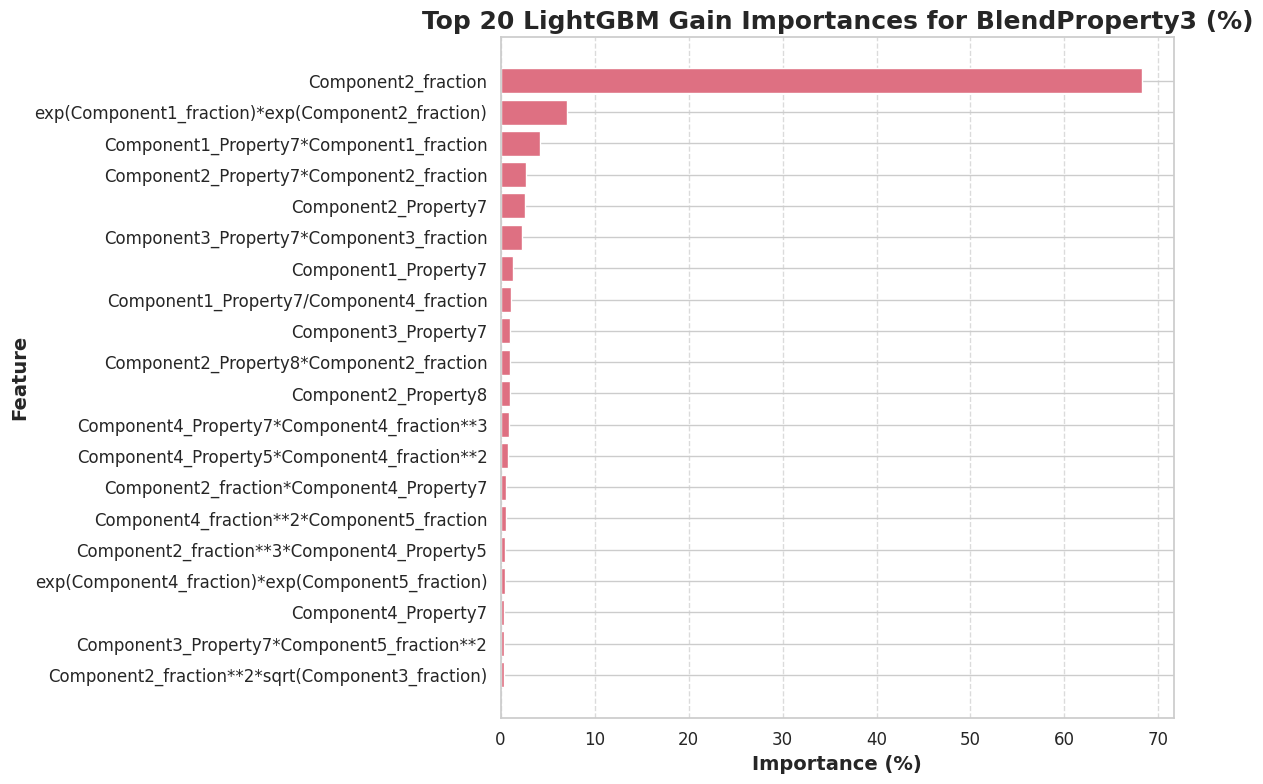

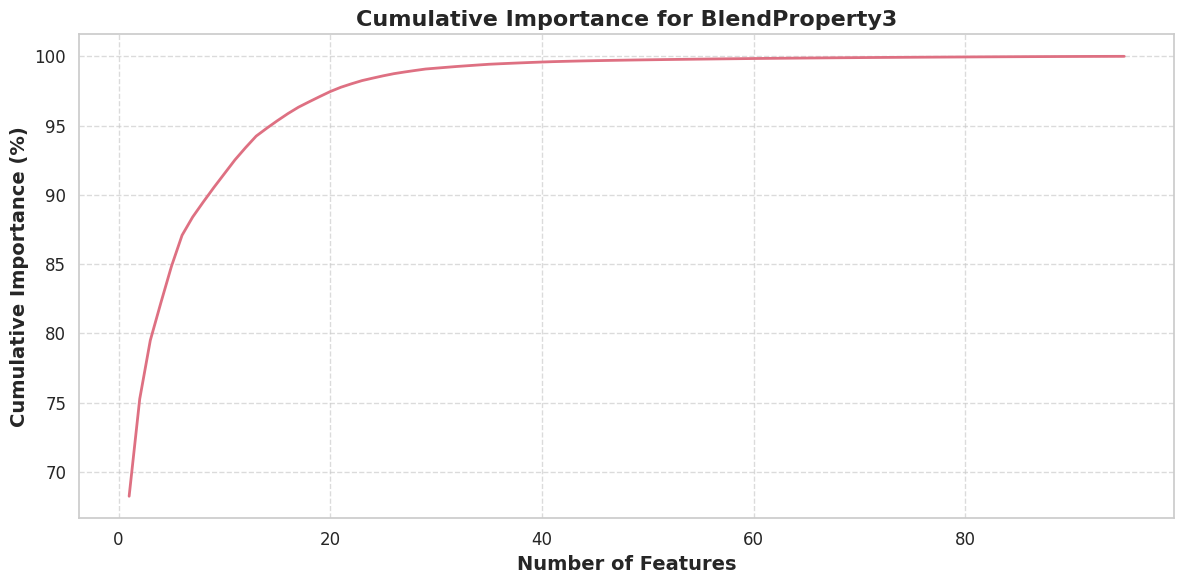


===== Computing LightGBM importances for BlendProperty2 =====
→ X_df.shape = (2000, 104), y_ser.shape = (2000,)
→ Fitting LGBMRegressor …
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25089
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 104
[LightGBM] [Info] Start training from score -0.002076
→ Model fitted; extracting feature_importances_ …
→ Top 20 features for BlendProperty2 (by % of total gain):
                                            feature  importance_pct
      sqrt(Component4_fraction)*Component5_fraction           34.55
  exp(Component1_fraction)*exp(Component2_fraction)           15.85
      Component3_fraction*exp(Component3_Property2)           10.70
      Component5_fraction*exp(Component5_Property2)            8.55
    

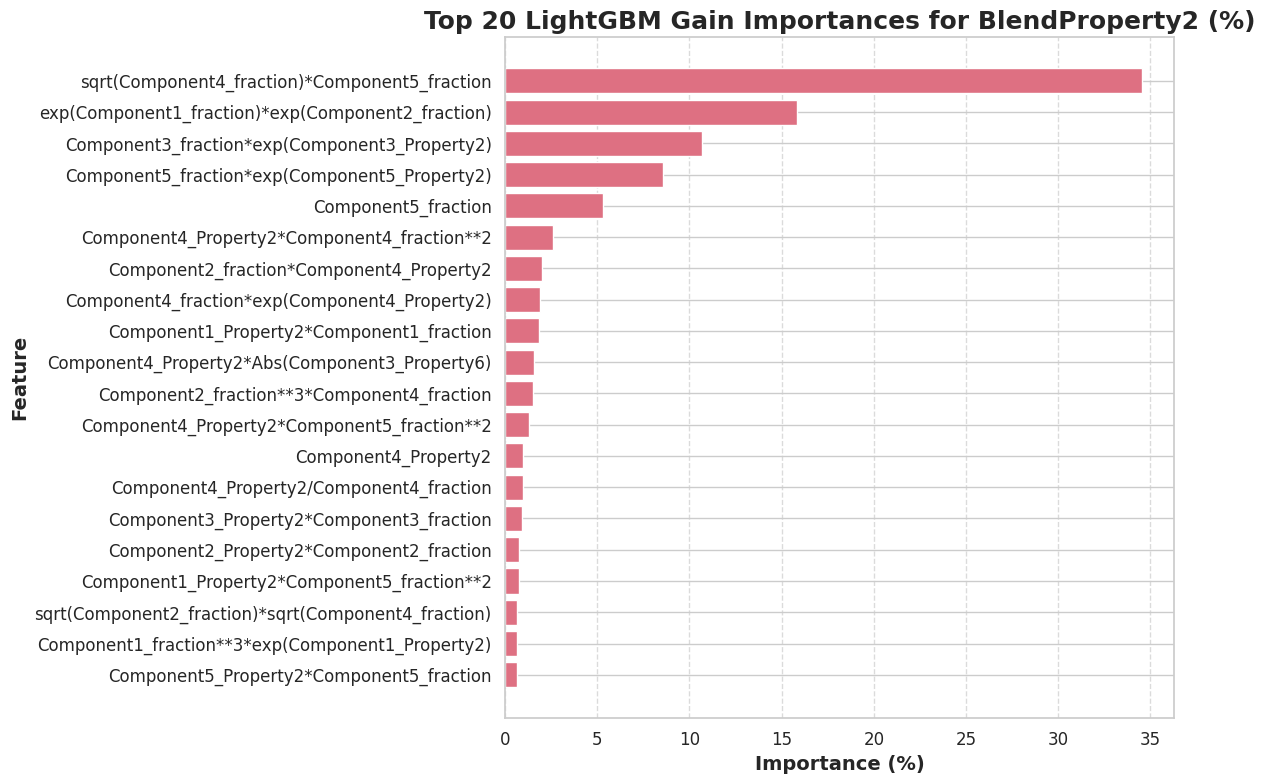

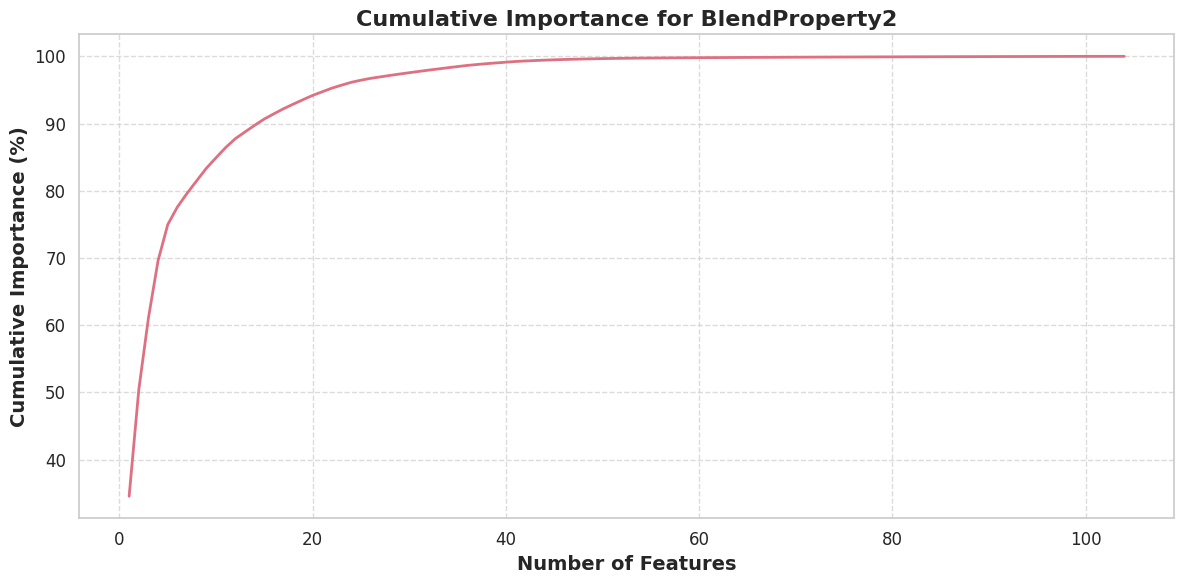


===== Computing LightGBM importances for BlendProperty7 =====
→ X_df.shape = (2000, 99), y_ser.shape = (2000,)
→ Fitting LGBMRegressor …
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23810
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 99
[LightGBM] [Info] Start training from score -0.013568
→ Model fitted; extracting feature_importances_ …
→ Top 20 features for BlendProperty7 (by % of total gain):
                                          feature  importance_pct
                              Component2_fraction           66.59
exp(Component1_fraction)*exp(Component2_fraction)            7.28
         Component1_Property7*Component1_fraction            4.22
         Component3_Property7*Component3_fraction            3.00
         Component2_Property7*Component2_fraction            2.73
              

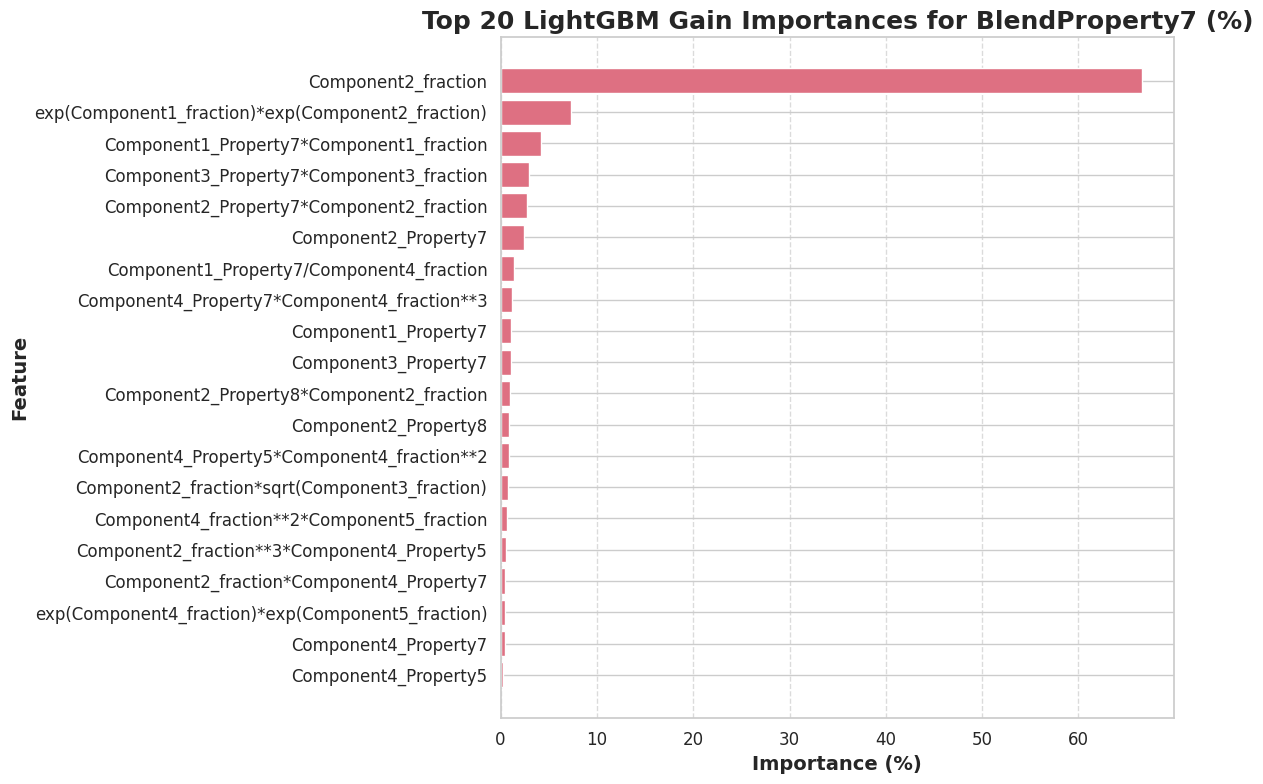

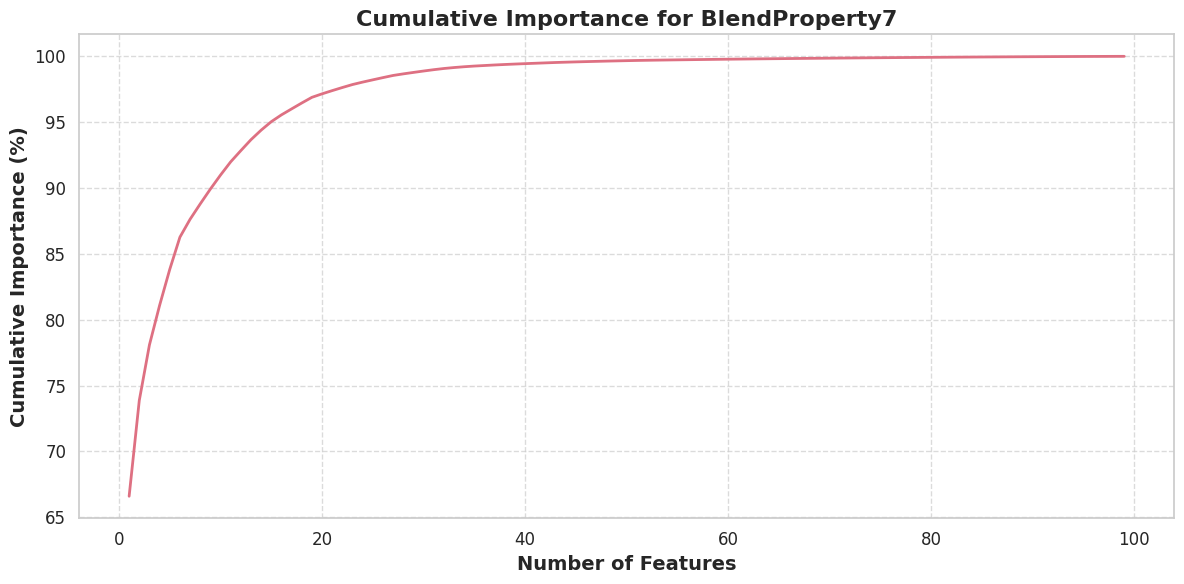


===== Computing LightGBM importances for BlendProperty5 =====
→ X_df.shape = (2000, 94), y_ser.shape = (2000,)
→ Fitting LGBMRegressor …
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22920
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 94
[LightGBM] [Info] Start training from score -0.015249
→ Model fitted; extracting feature_importances_ …
→ Top 20 features for BlendProperty5 (by % of total gain):
                                          feature  importance_pct
                              Component2_fraction           68.17
                             Component2_Property5           21.85
   Component1_Property5*sqrt(Component1_fraction)            4.94
                             Component1_Property5            1.64
      Component3_Property5*Component3_fraction**3            1.19
              

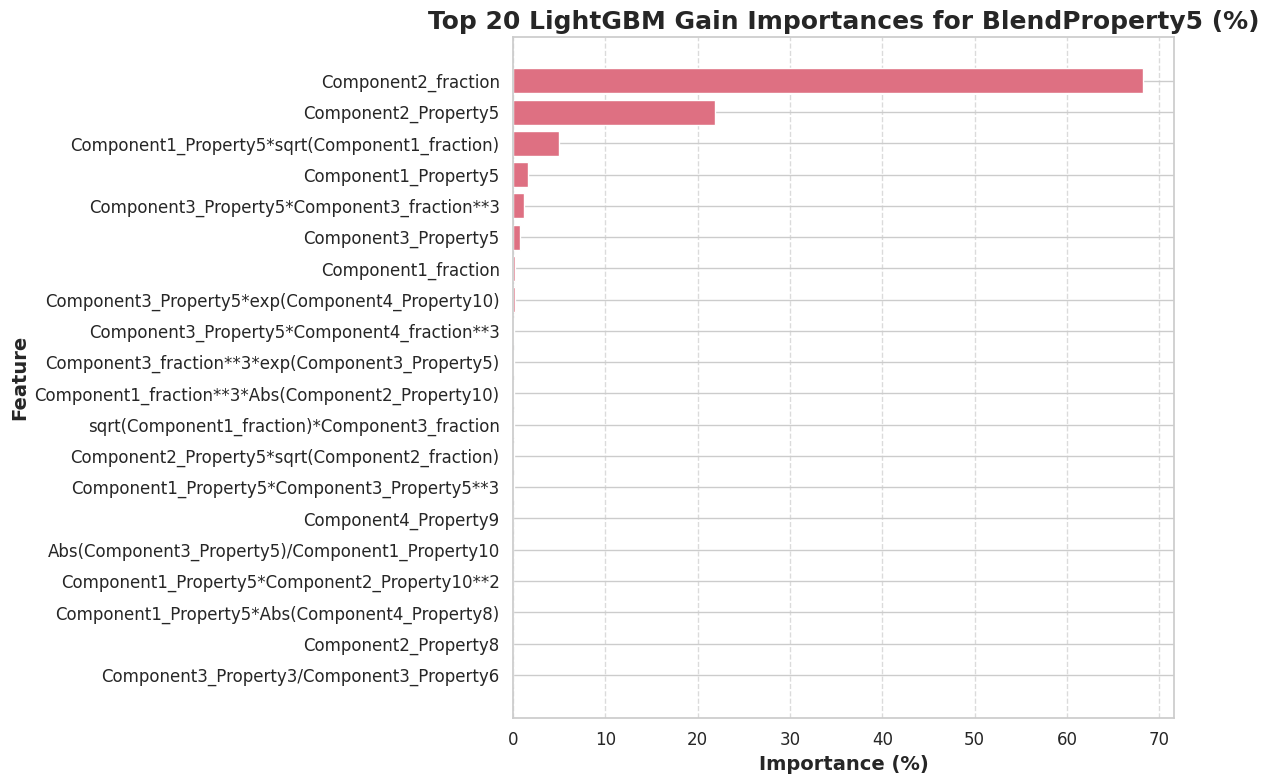

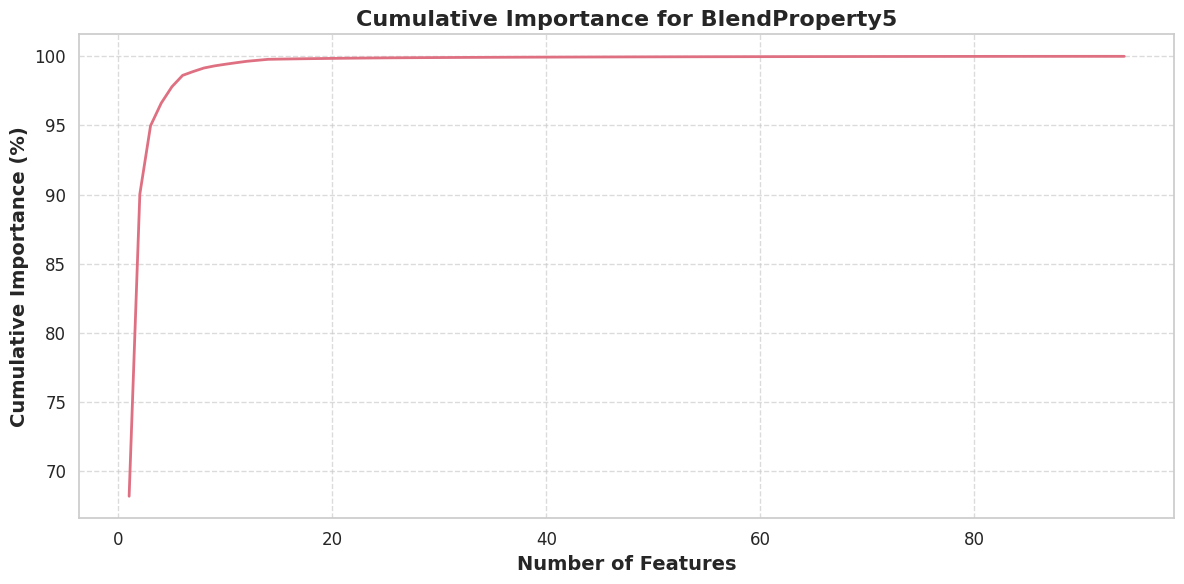


===== Computing LightGBM importances for BlendProperty8 =====
→ X_df.shape = (2000, 138), y_ser.shape = (2000,)
→ Fitting LGBMRegressor …
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33758
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 138
[LightGBM] [Info] Start training from score -0.017236
→ Model fitted; extracting feature_importances_ …
→ Top 20 features for BlendProperty8 (by % of total gain):
                                            feature  importance_pct
                                Component2_fraction           29.24
      sqrt(Component4_fraction)*Component5_fraction           11.04
           Component3_Property8*Component3_fraction            8.64
sqrt(Component2_fraction)*sqrt(Component4_fraction)            7.58
      sqrt(Component3_fraction)*Component5_fraction            6.42


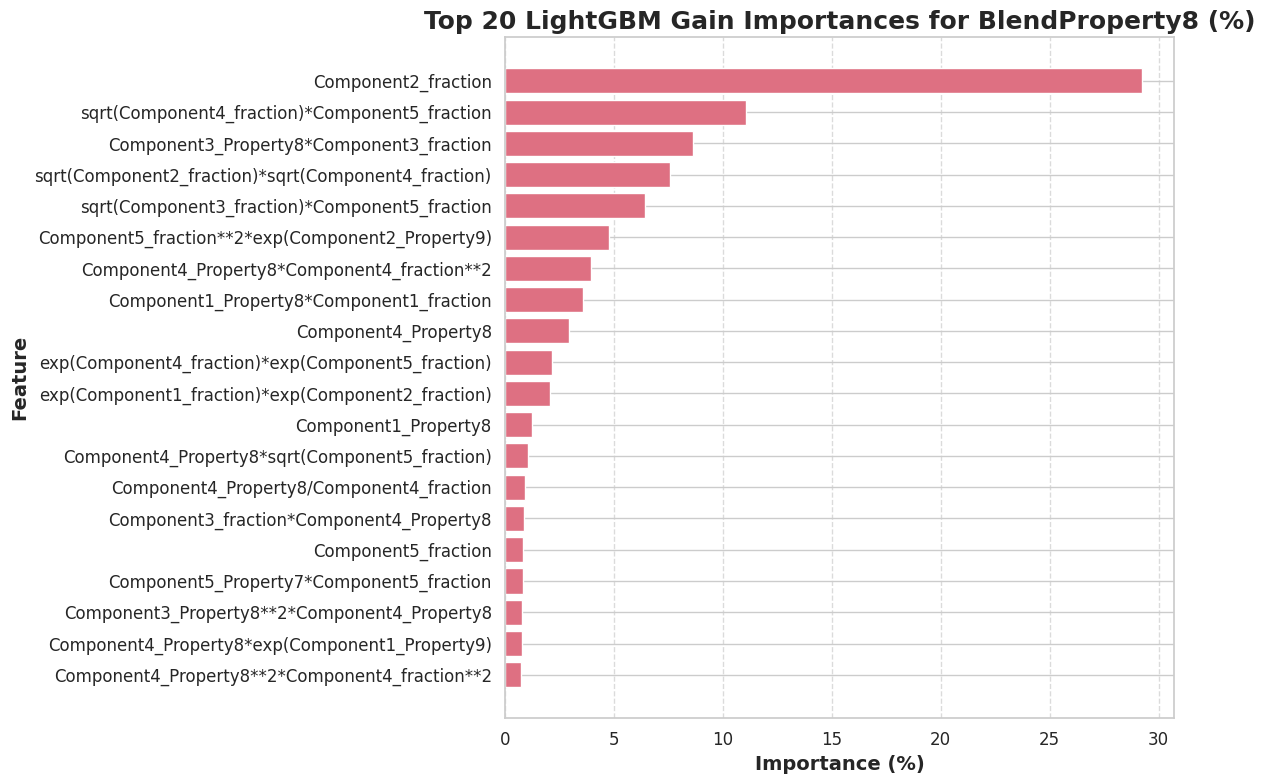

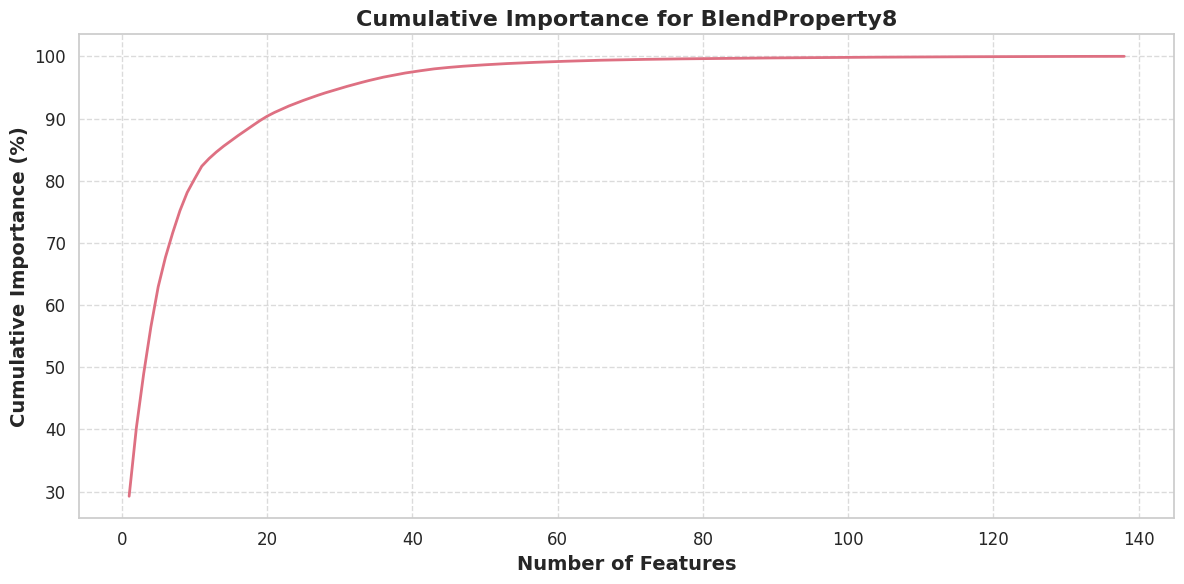


===== Computing LightGBM importances for BlendProperty4 =====
→ X_df.shape = (2000, 95), y_ser.shape = (2000,)
→ Fitting LGBMRegressor …
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22791
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 95
[LightGBM] [Info] Start training from score -0.006068
→ Model fitted; extracting feature_importances_ …
→ Top 20 features for BlendProperty4 (by % of total gain):
                                          feature  importance_pct
                              Component5_fraction           25.20
 Component5_fraction**2*exp(Component1_Property4)           17.78
exp(Component1_fraction)*exp(Component2_fraction)           13.78
         Component3_Property4*Component3_fraction            6.69
                              Component2_fraction            6.59
       Compone

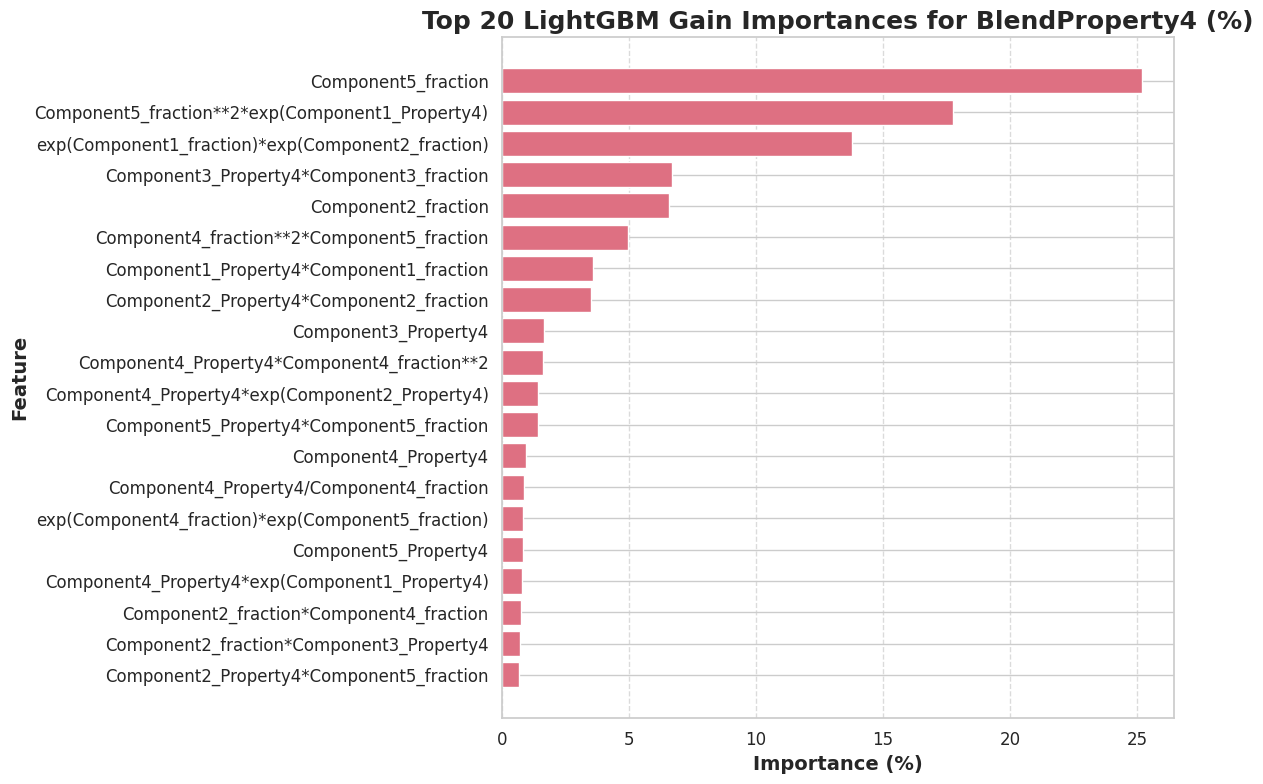

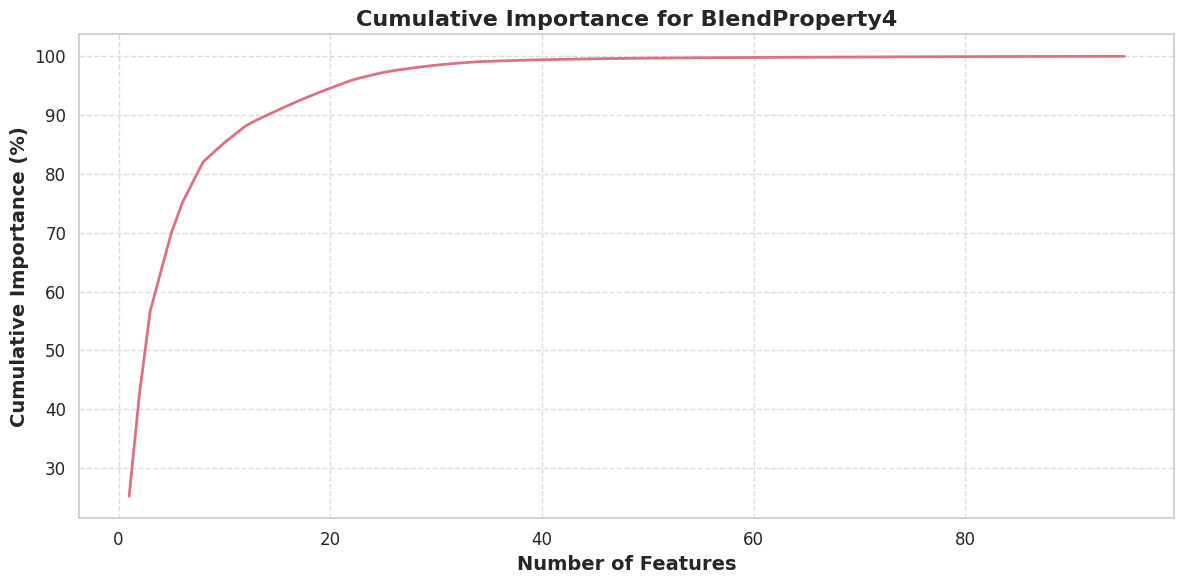


===== Computing LightGBM importances for BlendProperty10 =====
→ X_df.shape = (2000, 90), y_ser.shape = (2000,)
→ Fitting LGBMRegressor …
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20862
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 90
[LightGBM] [Info] Start training from score -0.001795
→ Model fitted; extracting feature_importances_ …
→ Top 20 features for BlendProperty10 (by % of total gain):
                                          feature  importance_pct
exp(Component4_fraction)*exp(Component5_fraction)           78.85
        Component3_Property10*Component3_fraction            7.94
                              Component2_fraction            2.81
       Component2_fraction**3*Component4_fraction            2.60
        Component1_Property10*Component1_fraction            2.46
        Comp

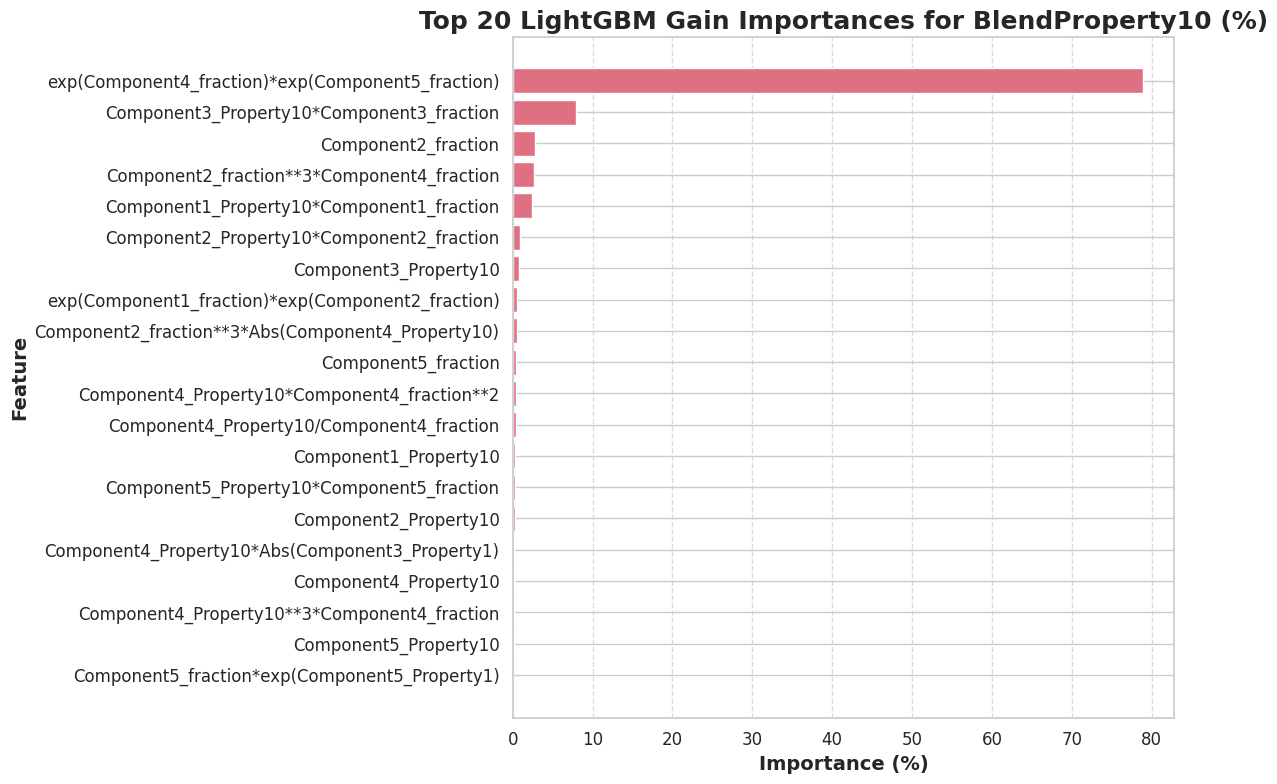

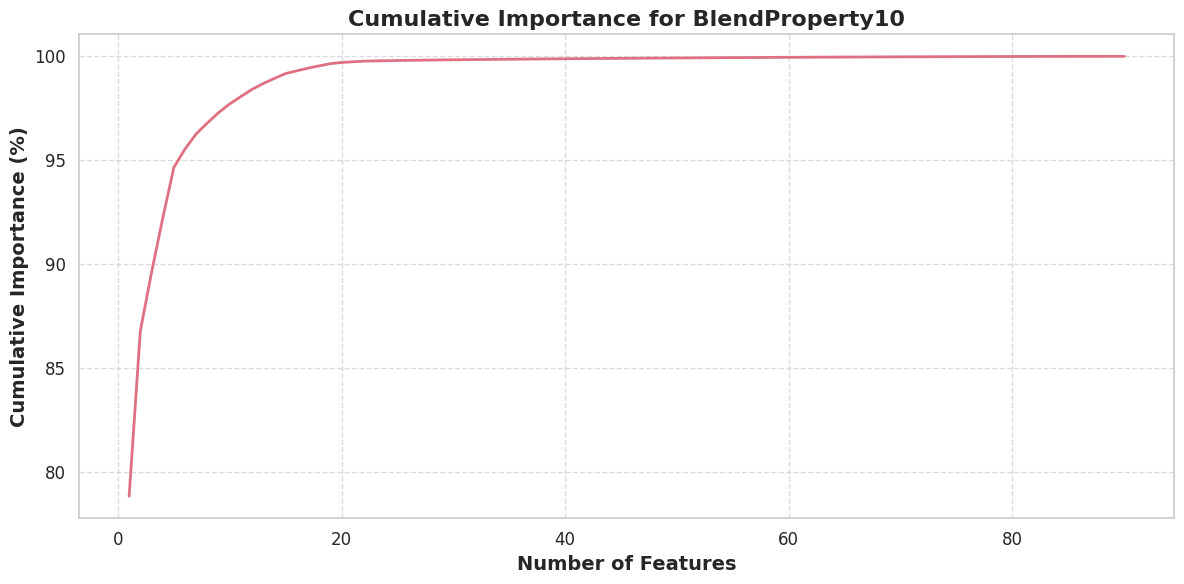


===== Computing LightGBM importances for BlendProperty6 =====
→ X_df.shape = (2000, 90), y_ser.shape = (2000,)
→ Fitting LGBMRegressor …
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21519
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 90
[LightGBM] [Info] Start training from score -0.003497
→ Model fitted; extracting feature_importances_ …
→ Top 20 features for BlendProperty6 (by % of total gain):
                                          feature  importance_pct
                              Component5_fraction           17.61
 Component5_fraction**2*exp(Component5_Property6)           16.66
         Component3_Property6*Component3_fraction           11.30
exp(Component1_fraction)*exp(Component2_fraction)           10.15
         Component1_Property6*Component1_fraction            6.69
      Componen

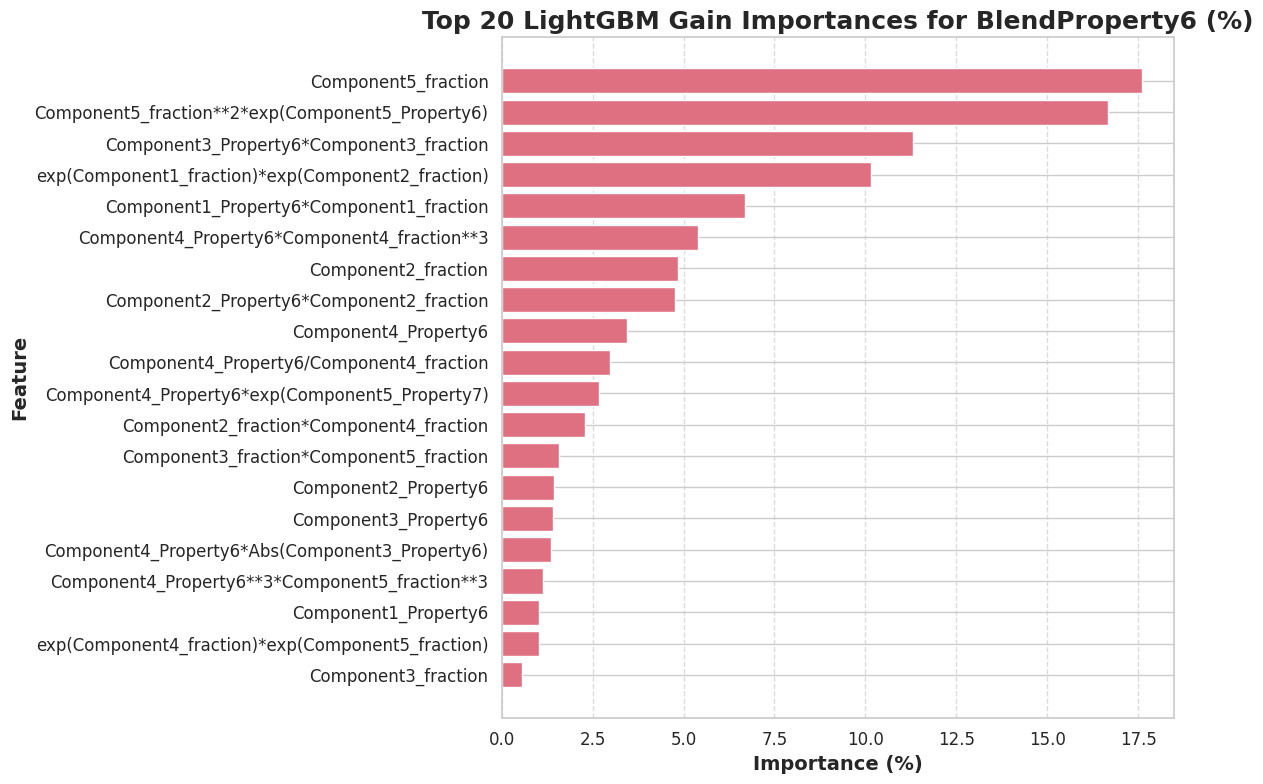

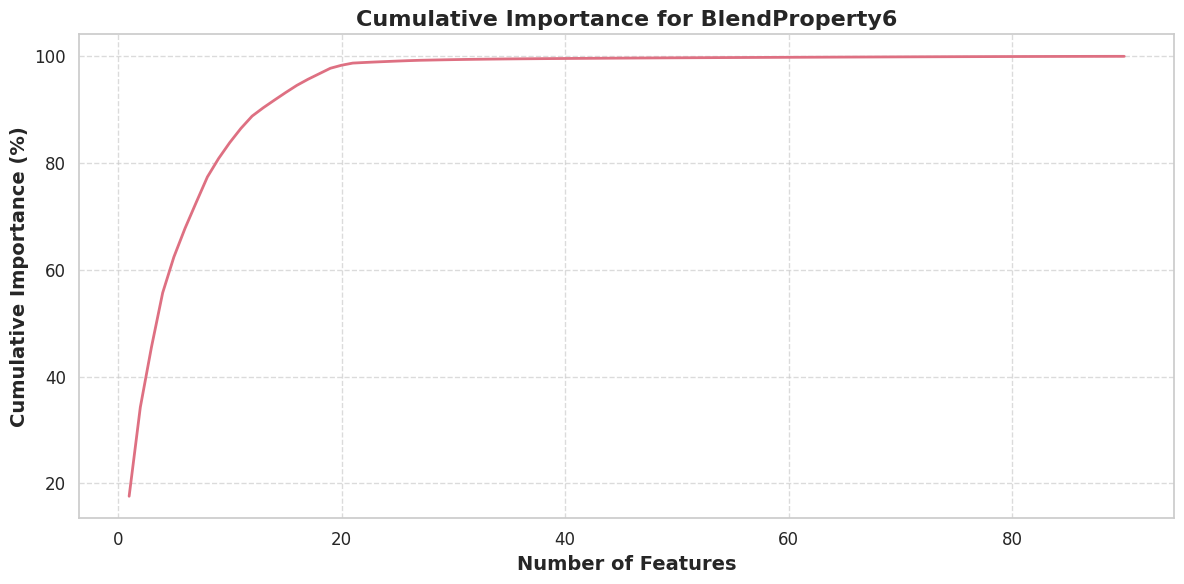


===== Computing LightGBM importances for BlendProperty1 =====
→ X_df.shape = (2000, 98), y_ser.shape = (2000,)
→ Fitting LGBMRegressor …
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23351
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 98
[LightGBM] [Info] Start training from score -0.016879
→ Model fitted; extracting feature_importances_ …
→ Top 20 features for BlendProperty1 (by % of total gain):
                                          feature  importance_pct
                              Component5_fraction           40.25
                              Component2_fraction           12.21
exp(Component1_fraction)*exp(Component2_fraction)            8.61
exp(Component4_fraction)*exp(Component5_fraction)            7.41
         Component3_Property1*Component3_fraction            6.03
    Component5

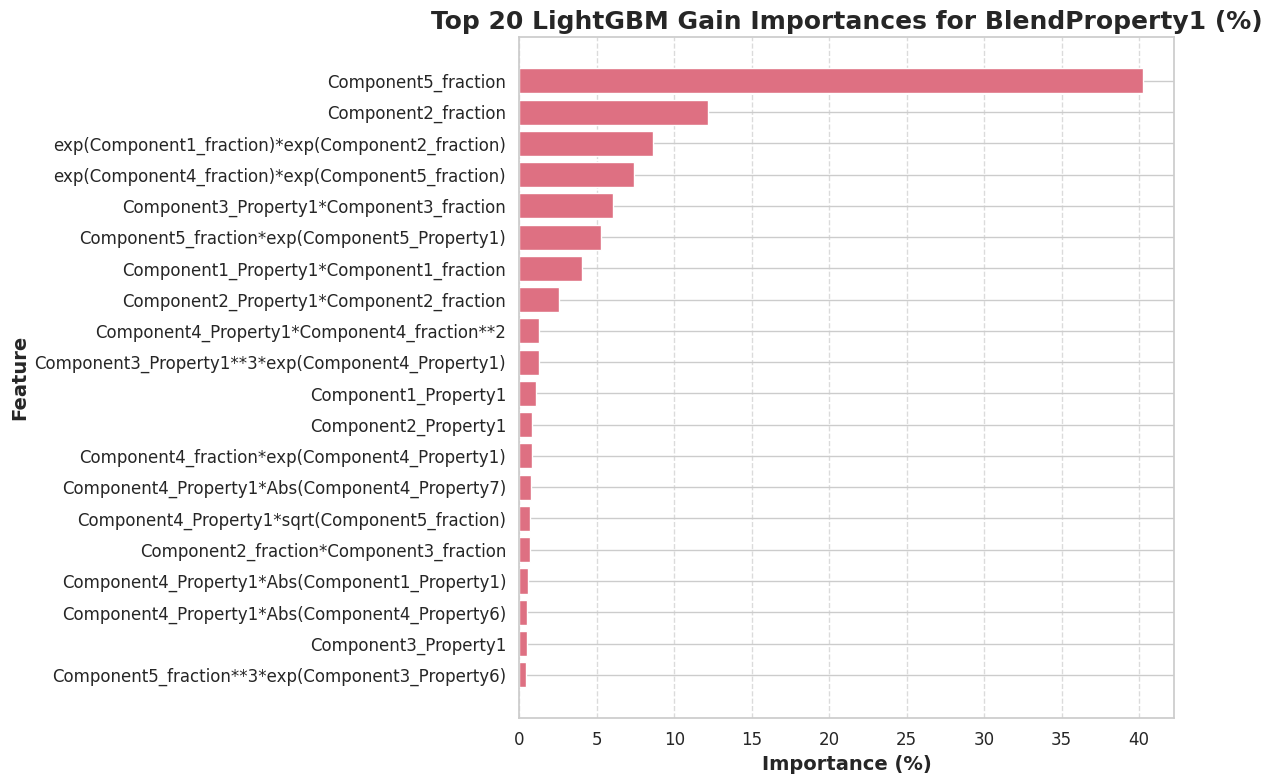

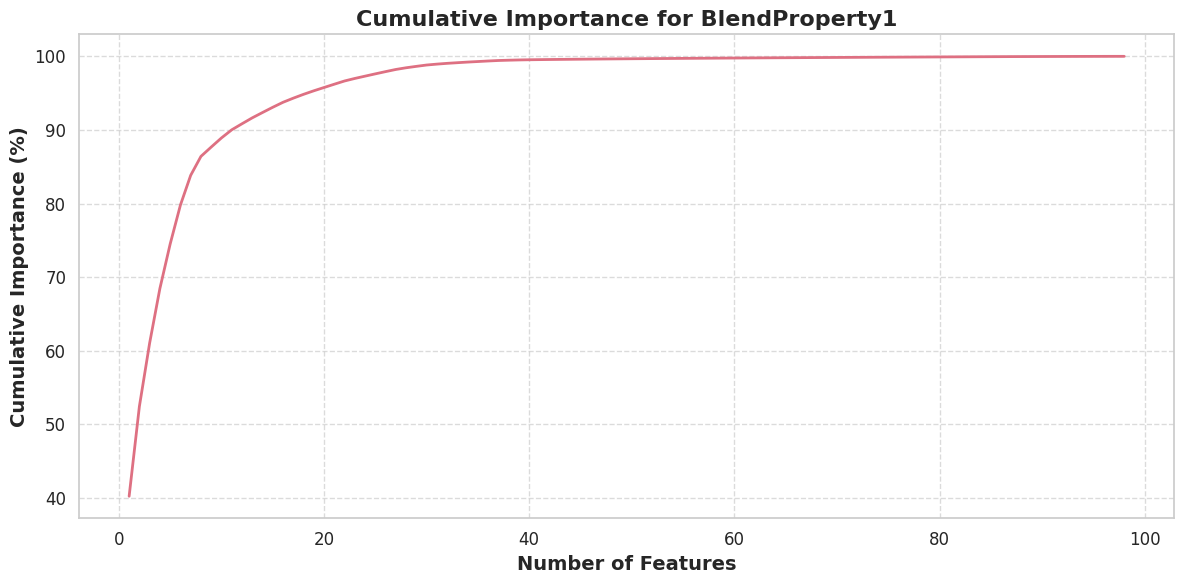


===== Computing LightGBM importances for BlendProperty9 =====
→ X_df.shape = (2000, 112), y_ser.shape = (2000,)
→ Fitting LGBMRegressor …
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27129
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 112
[LightGBM] [Info] Start training from score -0.001507
→ Model fitted; extracting feature_importances_ …
→ Top 20 features for BlendProperty9 (by % of total gain):
                                          feature  importance_pct
                              Component5_fraction           37.24
    Component5_fraction*exp(Component5_Property8)           11.02
      Component4_Property9*Component4_fraction**2           10.23
                             Component4_Property9            9.41
 Component5_fraction**2*exp(Component3_Property6)            6.31
         Com

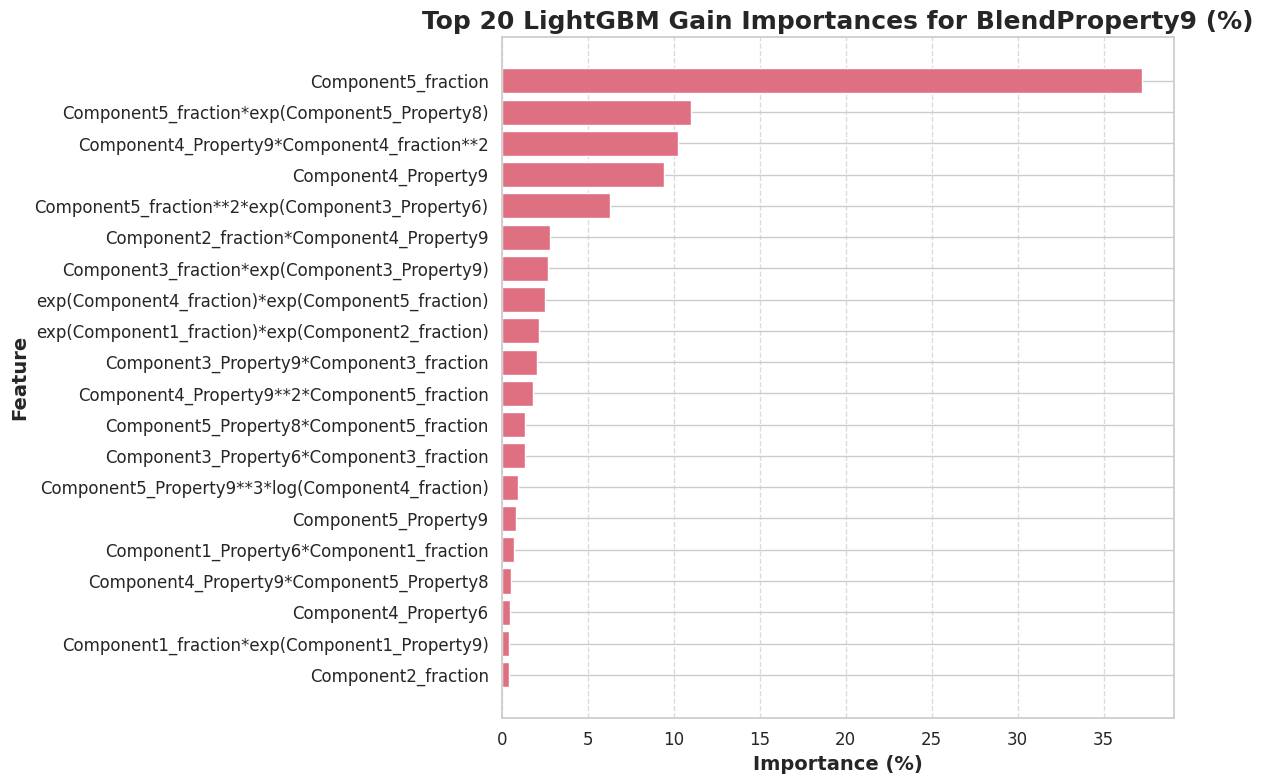

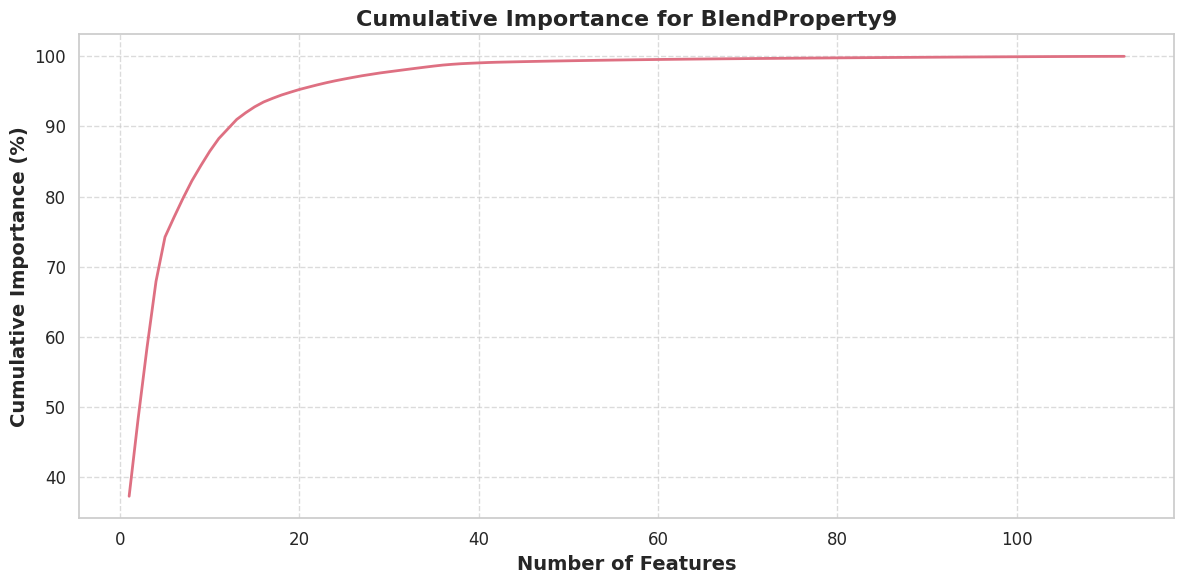

In [74]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from lightgbm import LGBMRegressor
from matplotlib.colors import LinearSegmentedColormap

# === Configurable parameter ===
TOP_N = 20

feature_importances = {}

for tgt, feats in pruned_feats_per_target.items():
    print(f"\n===== Computing LightGBM importances for {tgt} =====")
    
    # Prepare pruned feature matrix and target
    X_df = X_train_loaded[tgt][feats]
    y_ser = y_train[tgt]
    print(f"→ X_df.shape = {X_df.shape}, y_ser.shape = {y_ser.shape}")
    
    # Train LGBM with gain importances
    model = LGBMRegressor(random_state=42, n_jobs=-1, importance_type="gain")
    print("→ Fitting LGBMRegressor …")
    model.fit(X_df, y_ser)
    print("→ Model fitted; extracting feature_importances_ …")
    
    # Build & sort a DataFrame of importances
    imp_df = pd.DataFrame({
        "feature": feats,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False).reset_index(drop=True)
    
    # Convert to percentage of total gain and cumulative importance
    imp_df["importance_pct"] = imp_df["importance"] / imp_df["importance"].sum() * 100
    imp_df["cumulative_pct"] = imp_df["importance_pct"].cumsum()
    feature_importances[tgt] = imp_df
    
    # Print top N features
    print(f"→ Top {TOP_N} features for {tgt} (by % of total gain):")
    topN = imp_df.head(TOP_N)[["feature", "importance_pct"]]
    print(topN.to_string(index=False, float_format="{:.2f}".format))
    
    # === Plot 1: Top N features ===
    bar_color = nn_colors(0.8)
    plt.figure(figsize=(12, 8))
    plt.barh(topN["feature"][::-1], topN["importance_pct"][::-1],
             color=bar_color)
    plt.xlabel("Importance (%)", fontsize=14, fontweight="bold")
    plt.ylabel("Feature", fontsize=14, fontweight="bold")
    plt.title(f"Top {TOP_N} LightGBM Gain Importances for {tgt} (%)",
              fontsize=18, fontweight="bold")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"plots/feature_importances_{tgt}.png", dpi=300)
    plt.show()
    
    # === Plot 2: Cumulative importance ===
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(imp_df)+1), imp_df["cumulative_pct"], color=bar_color, linewidth=2)
    plt.xlabel("Number of Features", fontsize=14, fontweight="bold")
    plt.ylabel("Cumulative Importance (%)", fontsize=14, fontweight="bold")
    plt.title(f"Cumulative Importance for {tgt}", fontsize=16, fontweight="bold")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"plots/cumulative_importance_{tgt}.png", dpi=300)
    plt.show()


## Supervised Feature Selection Using Gain-Percent Thresholds with Validation-Driven Selection

In [12]:
# ─── Tweakable hyperparameters ───────────────────────
MIN_FEATURES      = 10           # minimum features to keep per target
TIME_BUDGET_SEC   = 20800        # total tuning time in seconds
CUTOFF_START      = 0.0025        # 0.1% 
CUTOFF_END        = 1.0          # 1.0%
CUTOFF_STEP       = 0.0025        # step of 0.1% 
VAL_FRACTION      = 0.20         # 80/20 split

# ─── Setup targets & storage ─────────────────────────
target_cols  = [f"BlendProperty{i}" for i in range(1, 11)]
best_results = {
    tgt: {"cutoff": None, "mape": float("inf")} for tgt in target_cols
}

# Precompute list of cutoffs
cutoffs = np.arange(CUTOFF_START, CUTOFF_END + 1e-8, CUTOFF_STEP) / 100.0

# ─── Precompute 80/20 indices per target ───────────
rng = np.random.RandomState(42)
split_indices = {}
for tgt in target_cols:
    n = len(y_train[tgt])
    idx = np.arange(n)
    rng.shuffle(idx)
    split = int((1 - VAL_FRACTION) * n)
    split_indices[tgt] = (idx[:split], idx[split:])  # (train_idx, val_idx)

start_time = time.time()
print(f"🔎 Starting cutoff sweep ({len(cutoffs)} values) for up to {TIME_BUDGET_SEC}s…\n")

for cutoff in cutoffs:
    elapsed = time.time() - start_time
    if elapsed > TIME_BUDGET_SEC:
        print(f"⏱️  Time budget exceeded ({elapsed:.0f}s), stopping sweep.")
        break

    print(f"\n=== Testing IMPORTANCE_CUTOFF = {cutoff*100:.4f}% (elapsed {elapsed:.0f}s) ===")
    for tgt in target_cols:
        imp_df = feature_importances[tgt]  # DataFrame with ['feature','importance_pct', …]

        # select and pad
        feats = imp_df.loc[imp_df["importance_pct"] > cutoff*100, "feature"].tolist()
        if len(feats) < MIN_FEATURES:
            pad = imp_df["feature"].head(MIN_FEATURES).tolist()
            feats = pad

        # slice data
        X_all = X_train_loaded[tgt][feats].values
        y_all = y_train[tgt].values

        train_idx, val_idx = split_indices[tgt]
        X_tr, y_tr = X_all[train_idx], y_all[train_idx]
        X_va, y_va = X_all[val_idx], y_all[val_idx]

        # train TabPFN
        try:
            model = TabPFNRegressor(device="cuda", random_state=42)
        except Exception:
            model = TabPFNRegressor(device="cpu", random_state=42)
        model.fit(X_tr, y_tr)

        # compute errors
        train_pred = model.predict(X_tr)
        val_pred   = model.predict(X_va)

        train_err = mape(y_tr, train_pred) * 100
        val_err   = mape(y_va, val_pred) * 100

        # record if best (by validation)
        if val_err < best_results[tgt]["mape"]:
            best_results[tgt]["mape"]   = val_err
            best_results[tgt]["cutoff"] = cutoff * 100

        print(f"• {tgt:15}: feats={len(feats):3} | train‑MAPE={train_err:6.4f}% | "
              f"val‑MAPE={val_err:6.4f}% | best={best_results[tgt]['mape']:.4f}% @ {best_results[tgt]['cutoff']:.4f}%")

# ─── Summary ────────────────────────────────────────────
print("\n✅ Sweep complete! Best cutoffs per target (by 20% hold‑out MAPE):")
for tgt, info in best_results.items():
    print(f"  {tgt:15}: {info['cutoff']:.4f}% → MAPE = {info['mape']:.4f}%")


🔎 Starting cutoff sweep (400 values) for up to 20800s…


=== Testing IMPORTANCE_CUTOFF = 0.0025% (elapsed 0s) ===
• BlendProperty1 : feats= 97 | train‑MAPE=19.2316% | val‑MAPE=7.9276% | best=7.9276% @ 0.0025%
• BlendProperty2 : feats=101 | train‑MAPE=6.0169% | val‑MAPE=7.8297% | best=7.8297% @ 0.0025%
• BlendProperty3 : feats= 92 | train‑MAPE=14.1498% | val‑MAPE=37.1622% | best=37.1622% @ 0.0025%
• BlendProperty4 : feats= 92 | train‑MAPE=4.3164% | val‑MAPE=15.6228% | best=15.6228% @ 0.0025%
• BlendProperty5 : feats= 38 | train‑MAPE=1.1628% | val‑MAPE=8.2996% | best=8.2996% @ 0.0025%
• BlendProperty6 : feats= 89 | train‑MAPE=5.6014% | val‑MAPE=7.5192% | best=7.5192% @ 0.0025%
• BlendProperty7 : feats= 98 | train‑MAPE=13.6431% | val‑MAPE=26.1009% | best=26.1009% @ 0.0025%
• BlendProperty8 : feats=133 | train‑MAPE=22.5122% | val‑MAPE=20.8846% | best=20.8846% @ 0.0025%
• BlendProperty9 : feats=112 | train‑MAPE=14.8481% | val‑MAPE=43.8545% | best=43.8545% @ 0.0025%
• BlendProperty10: feats=

Calculating feature counts from your loaded data...
Counts calculated.
Generating plot...
Plot saved to plots/feature_funnel_matplotlib.png


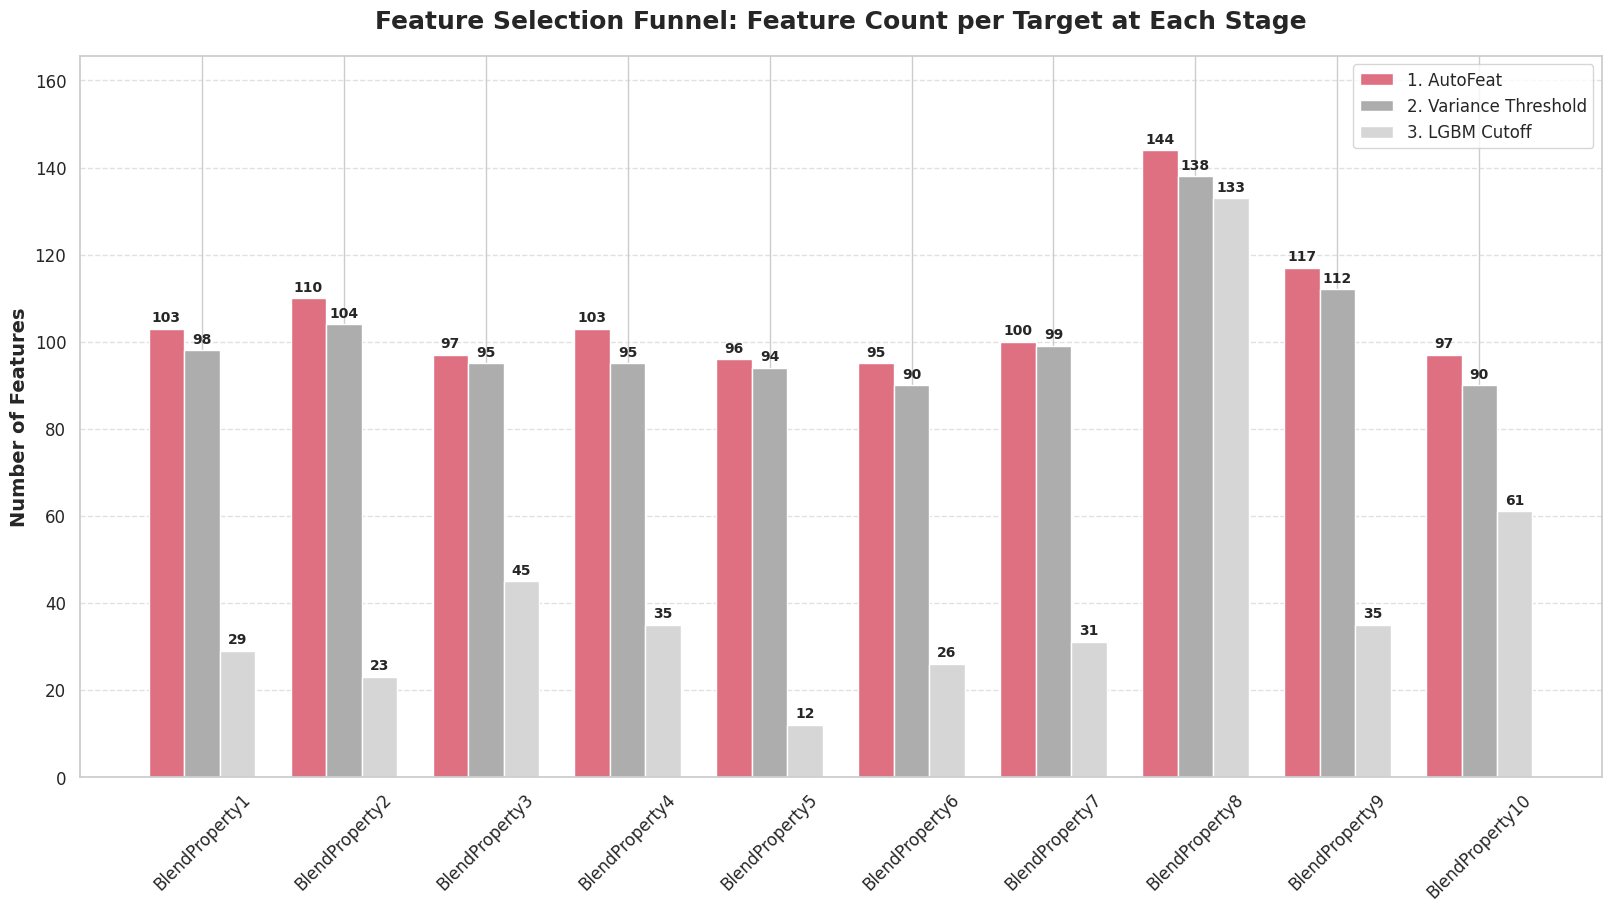

In [95]:
# 1. CALCULATE FEATURE COUNTS AT EACH STAGE

print("Calculating feature counts from your loaded data...")

results = []
stages_order = ["1. AutoFeat", "2. Variance Threshold", "3. LGBM Cutoff"]
# ─── Feature Selection Params ──────────────────────────────
MIN_FEATURES = 10
best_cutoffs = {
    "BlendProperty1":  0.1825, "BlendProperty2":  0.4225,
    "BlendProperty3":  0.0150, "BlendProperty4":  0.0625,
    "BlendProperty5":  0.0750, "BlendProperty6":  0.0675,
    "BlendProperty7":  0.0925, "BlendProperty8":  0.0025,
    "BlendProperty9":  0.1425, "BlendProperty10": 0.0025,
}

for tgt in target_cols:
    # Stage 1: After AutoFeat FE
    df_initial = X_train_loaded[tgt]
    count_after_autofeat = df_initial.shape[1]
    results.append({"target": tgt, "stage": stages_order[0], "count": count_after_autofeat})

    # Stage 2: After Variance Threshold
    domain_cols = df_initial.columns.tolist()[:N_DOMAIN]
    eng_cols = df_initial.columns.tolist()[N_DOMAIN:]
    vars_series = df_initial.var(ddof=0)
    high_var_eng = [c for c in eng_cols if vars_series[c] >= VAR_THRESH]
    count_after_variance = len(domain_cols) + len(high_var_eng)
    results.append({"target": tgt, "stage": stages_order[1], "count": count_after_variance})

    # Stage 3: After LGBM Importance Cutoff
    imp_df = feature_importances[tgt]
    cutoff = best_cutoffs[tgt]
    feats = imp_df.loc[imp_df["importance_pct"] > cutoff, "feature"].tolist()
    if len(feats) < MIN_FEATURES:
        feats = imp_df["feature"].head(MIN_FEATURES).tolist()
    count_after_lgbm = len(feats)
    results.append({"target": tgt, "stage": stages_order[2], "count": count_after_lgbm})

plot_df = pd.DataFrame(results)
print("Counts calculated.")

# Plot results
print("Generating plot...")

targets = plot_df['target'].unique()
x = np.arange(len(targets))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(16, 9), layout='constrained')

# Color mapping for stages
stage_colors = {
    "1. AutoFeat": nn_colors(0.8),
    "2. Variance Threshold": nn_colors(0.1),
    "3. LGBM Cutoff": nn_colors(0.3)
}

for stage, group_df in plot_df.groupby('stage'):
    # Reorder the group_df to match the order of targets
    group_df = group_df.set_index('target').reindex(targets)
    
    offset = width * multiplier
    rects = ax.bar(x + offset, group_df['count'], width,
                   label=stage, color=stage_colors.get(stage, nn_colors(0.5)))
    ax.bar_label(rects, padding=3, fontsize=10, weight='bold')
    multiplier += 1

# Add labels, title, and axes ticks
ax.set_ylabel('Number of Features', fontsize=14, fontweight='bold')
ax.set_title('Feature Selection Funnel: Feature Count per Target at Each Stage', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x + width, targets)
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(loc='upper right', ncols=1, fontsize=12)
ax.set_ylim(0, plot_df['count'].max() * 1.15)  
ax.grid(axis='y', linestyle='--', alpha=0.6)  

plt.savefig("plots/feature_funnel_matplotlib.png", dpi=300)
print("Plot saved to plots/feature_funnel_matplotlib.png")

plt.show()


# Model Training and Prediction

## Solution Pipeline 1: Model Training and Prediction using TabPFN with Hyperparameter Sweep (Using Selected Features from Feature Importance Pipeline)

In [18]:
# ─── Hyperparameter Grid ───────────────────────────────
param_grid = {
    "n_estimators": [16, 24, 32, 64],
    "softmax_temperature": [0.8, 0.9, 1.0],
    "average_before_softmax": [True],
    "random_state": [0, 20, 40],
}

# ─── Setup Output & Targets ────────────────────────────
output_dir = "./lgb_shap"
os.makedirs(output_dir, exist_ok=True)
print(f"📁 Submission candidates will be saved to: '{output_dir}/'")

target_cols = [f"BlendProperty{i}" for i in range(1, 11)]
n_test = len(next(iter(X_test_loaded.values())))

total_configs = (
    len(param_grid["n_estimators"]) *
    len(param_grid["softmax_temperature"]) *
    len(param_grid["average_before_softmax"]) *
    len(param_grid["random_state"])
)
print(f"🚀 Generating submissions for {total_configs} hyperparameter configs…")

meta_all = []
config_count = 0

# ─── Loop Over Hyperparameter Combos ───────────────────
for n_est in param_grid["n_estimators"]:
    for temp in param_grid["softmax_temperature"]:
        for avg_before in param_grid["average_before_softmax"]:
            for seed in param_grid["random_state"]:

                config_count += 1
                cfg_name = f"n{n_est}_temp{temp}_avg{avg_before}_s{seed}"
                print(f"\n🎯 Config {config_count}/{total_configs}: {cfg_name}")

                cfg_dir = os.path.join(output_dir, cfg_name)
                os.makedirs(cfg_dir, exist_ok=True)

                submission_df = pd.DataFrame({"ID": np.arange(1, n_test + 1)})
                meta_cfg = {"config": {
                                "n_estimators": n_est,
                                "softmax_temperature": temp,
                                "average_before_softmax": avg_before,
                                "random_state": seed
                            },
                            "targets": []}

                for tgt in target_cols:
                    cutoff = best_cutoffs[tgt]
                    imp_df = feature_importances[tgt]  # ['feature','importance_pct',...]

                    # Select features > cutoff (values already in percent form)
                    feats = imp_df.loc[imp_df["importance_pct"] > cutoff, "feature"].tolist()

                    # Enforce minimum count
                    if len(feats) < MIN_FEATURES:
                        feats = imp_df["feature"].head(MIN_FEATURES).tolist()

                    # Build train/test
                    X_tr_df = X_train_loaded[tgt][feats]
                    y_tr    = y_train[tgt].values
                    X_te_df = X_test_loaded[tgt][feats]

                    X_tr = X_tr_df.values
                    X_te = X_te_df.values

                    # Train TabPFN
                    try:
                        model = TabPFNRegressor(
                            device="cuda",
                            n_estimators=n_est,
                            softmax_temperature=temp,
                            average_before_softmax=avg_before,
                            random_state=seed
                        )
                    except Exception:
                        model = TabPFNRegressor(
                            device="cpu",
                            n_estimators=n_est,
                            softmax_temperature=temp,
                            average_before_softmax=avg_before,
                            random_state=seed
                        )

                    model.fit(X_tr, y_tr)

                    # Predict & record
                    preds = model.predict(X_te)
                    submission_df[tgt] = preds

                    # Train MAPE sanity check
                    train_pred = model.predict(X_tr)
                    train_err  = mape(y_tr, train_pred) * 100
                    print(f"  🔹 {tgt:<15} | {len(feats):>3} feats | train-MAPE: {train_err:>5.2f}%")

                    # Dump candidate artifacts
                    tgt_dir = os.path.join(cfg_dir, tgt)
                    os.makedirs(tgt_dir, exist_ok=True)

                    feat_path  = os.path.join(tgt_dir, "features.json")
                    train_path = os.path.join(tgt_dir, "train.csv")
                    test_path  = os.path.join(tgt_dir, "test.csv")
                    preds_path = os.path.join(tgt_dir, f"preds_{tgt}.csv")

                    with open(feat_path, "w") as f:
                        json.dump({"features": feats, "cutoff_pct": float(cutoff)}, f, indent=2)

                    # include label in train CSV for LGB
                    X_tr_df.assign(**{tgt: y_train[tgt].values}).to_csv(train_path, index=False)
                    X_te_df.to_csv(test_path, index=False)
                    pd.DataFrame({"ID": np.arange(1, n_test + 1), tgt: preds}).to_csv(preds_path, index=False)

                    meta_cfg["targets"].append({
                        "target": tgt,
                        "cutoff_pct": float(cutoff),
                        "num_feats": len(feats),
                        "train_mape": float(train_err),
                        "paths": {
                            "features": feat_path,
                            "train_csv": train_path,
                            "test_csv": test_path,
                            "preds_csv": preds_path
                        }
                    })

                # Save submission for this config
                fpath = os.path.join(cfg_dir, f"submission_{cfg_name}.csv")
                submission_df.to_csv(fpath, index=False)
                meta_cfg["submission_csv"] = fpath
                meta_all.append(meta_cfg)
                print(f"  ✅ Saved Candidate: {fpath}")

# ─── Global Summary ─────────────────────────────────────
summary_path = os.path.join(output_dir, "meta_summary.json")
with open(summary_path, "w") as f:
    json.dump(meta_all, f, indent=2)

print("\n🏁 DONE! All submission candidates generated.")
print(f"🧾 Global summary saved to: {summary_path}")

📁 Submission candidates will be saved to: './lgb_shap/'
🚀 Generating submissions for 36 hyperparameter configs…

🎯 Config 1/36: n16_temp0.8_avgTrue_s0
  🔹 BlendProperty1  |  29 feats | train-MAPE:  5.26%
  🔹 BlendProperty2  |  23 feats | train-MAPE:  3.13%
  🔹 BlendProperty3  |  45 feats | train-MAPE:  9.57%
  🔹 BlendProperty4  |  35 feats | train-MAPE:  4.84%
  🔹 BlendProperty5  |  12 feats | train-MAPE:  0.76%
  🔹 BlendProperty6  |  26 feats | train-MAPE:  4.26%
  🔹 BlendProperty7  |  31 feats | train-MAPE:  9.36%
  🔹 BlendProperty8  | 133 feats | train-MAPE: 15.84%
  🔹 BlendProperty9  |  35 feats | train-MAPE: 10.48%
  🔹 BlendProperty10 |  61 feats | train-MAPE:  6.09%
  ✅ Saved Candidate: ./lgb_shap/n16_temp0.8_avgTrue_s0/submission_n16_temp0.8_avgTrue_s0.csv

🎯 Config 2/36: n16_temp0.8_avgTrue_s20
  🔹 BlendProperty1  |  29 feats | train-MAPE:  8.99%
  🔹 BlendProperty2  |  23 feats | train-MAPE:  3.73%
  🔹 BlendProperty3  |  45 feats | train-MAPE: 10.60%
  🔹 BlendProperty4  |  35 f

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.38 GiB. GPU 0 has a total capacity of 7.63 GiB of which 1.76 GiB is free. Including non-PyTorch memory, this process has 5.86 GiB memory in use. Of the allocated memory 5.02 GiB is allocated by PyTorch, and 732.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Solution Pipeline 2: Model Training and Prediction using TabPFN with Hyperparameter Sweep (Using Variance-Based Feature Selection Only)

In [9]:
# ------------------------------------------------------------------
# Define the 10 targets
target_cols = [f"BlendProperty{i}" for i in range(1, 11)]

# Sanity checks
assert all(col in X_train_loaded for col in target_cols), "Missing target in X_train_loaded!"
assert all(col in X_test_loaded  for col in target_cols), "Missing target in X_test_loaded!"
assert all(col in y_train.columns for col in target_cols),  "Missing target in y_train!"

# Prep submission DataFrame
n_test = len(next(iter(X_test_loaded.values())))  # take length from the first target
submission_pruned_df = pd.DataFrame({"ID": np.arange(1, n_test + 1)})

print("🚀 Training TabPFN per target using pruned features…")
for tgt in target_cols:
    # Pull in the pruned feature list for this target
    feats = pruned_feats_per_target[tgt]
    print(f"\n🎯 {tgt}: using {len(feats)} pruned features")
    
    # – get your arrays using only the pruned cols
    X_tr = X_train_loaded[tgt][feats].values
    y_tr = y_train[tgt].values
    X_te = X_test_loaded[tgt][feats].values

    print(f"   → X_tr.shape = {X_tr.shape}, X_te.shape = {X_te.shape}")
    
    # – init & train on GPU (fallback to CPU if needed)
    try:
        model = TabPFNRegressor(
            device="cuda",
            n_estimators=16,
            average_before_softmax=True,
            softmax_temperature=1.0,
            random_state=0,
            ignore_pretraining_limits=True
        )
        print("   ↪️  GPU mode ON")
    except Exception:
        model = TabPFNRegressor(device="cpu", random_state=40)
        print("   ↪️  GPU failed, using CPU")
    
    print("   → Fitting model…")
    model.fit(X_tr, y_tr)
    print("   → Model training complete")

    # – predict
    preds = model.predict(X_te)                # (n_test,) array of floats
    submission_pruned_df[tgt] = preds

    # – quick self‑check on training data
    train_preds = model.predict(X_tr)
    train_mape = mape(y_tr, train_preds) * 100  # [MAPE = mean absolute % error]
    print(f"   • {tgt}: train‑MAPE = {train_mape:.2f}%   |   test rows = {len(preds)}")

print("\n✅ All targets done; preview:")
display(submission_pruned_df.head())
submission_pruned_df.to_csv("submission_pruned.csv", index=False)
print("📄 Saved → submission_pruned.csv.csv")

🚀 Training TabPFN per target using pruned features…

🎯 BlendProperty1: using 98 pruned features
   → X_tr.shape = (2000, 98), X_te.shape = (500, 98)
   ↪️  GPU mode ON
   → Fitting model…
   → Model training complete
   • BlendProperty1: train‑MAPE = 12.91%   |   test rows = 500

🎯 BlendProperty2: using 104 pruned features
   → X_tr.shape = (2000, 104), X_te.shape = (500, 104)
   ↪️  GPU mode ON
   → Fitting model…
   → Model training complete
   • BlendProperty2: train‑MAPE = 5.35%   |   test rows = 500

🎯 BlendProperty3: using 95 pruned features
   → X_tr.shape = (2000, 95), X_te.shape = (500, 95)
   ↪️  GPU mode ON
   → Fitting model…
   → Model training complete
   • BlendProperty3: train‑MAPE = 15.14%   |   test rows = 500

🎯 BlendProperty4: using 95 pruned features
   → X_tr.shape = (2000, 95), X_te.shape = (500, 95)
   ↪️  GPU mode ON
   → Fitting model…
   → Model training complete
   • BlendProperty4: train‑MAPE = 6.48%   |   test rows = 500

🎯 BlendProperty5: using 94 pruned 

ID  BlendProperty1  BlendProperty2  BlendProperty3  BlendProperty4  \
0   1        0.151236        0.267593        0.706599        0.573676   
1   2       -0.819617       -0.586450       -1.176179        0.055311   
2   3        1.770966        1.136843        1.052147        1.061174   
3   4       -0.477018        0.297414        0.850552       -0.729013   
4   5        0.118161       -1.170675        1.150229        0.454888   

   BlendProperty5  BlendProperty6  BlendProperty7  BlendProperty8  \
0        0.350867        0.710736        0.669952        0.352324   
1       -0.728155       -0.096034       -1.171692       -1.026075   
2        2.416299        1.842371        1.050755        2.042015   
3        1.908554       -0.468972        0.836303        1.690944   
4        2.377067        0.241455        1.135395       -0.061232   

   BlendProperty9  BlendProperty10  
0       -0.349684         0.320795  
1       -0.868304        -0.013934  
2        0.699964         2.214871  
3        0.902687        -0.962511  
4       -0.498703         1.047349

📄 Saved → submission_pruned.csv.csv


## Solution Pipeline 3: Model Training and Prediction using TabPFN with Hyperparameter Sweep (Using Engineered Features from Autofeat Only)

In [6]:
# ─── Hyperparameter Grid (yours) ───────────────────────
param_grid = {
    "n_estimators": [32], # tried others [16, 32, 64]
    "softmax_temperature": [0.95, 1.0, 1.05],
    "average_before_softmax": [True],
    "random_state": [18, 20, 22, 24], # tried others [0, 20, 40]
}

# ─── Targets ────────────────────────────────────────────
target_cols = [f"BlendProperty{i}" for i in range(1, 11)]

# ─── Output dir ─────────────────────────────────────────
output_dir = "./raw_FE"
os.makedirs(output_dir, exist_ok=True)
print(f"📁 Submission candidates will be saved to: '{output_dir}/'")

n_test = len(next(iter(X_test_loaded.values())))

total_configs = (
    len(param_grid["n_estimators"]) *
    len(param_grid["softmax_temperature"]) *
    len(param_grid["average_before_softmax"]) *
    len(param_grid["random_state"])
)
print(f"🚀 Generating submissions for {total_configs} hyperparameter configs…")

meta_all = []
config_count = 0

# ─── Sweep combos ───────────────────────────────────────
for n_est in param_grid["n_estimators"]:
    for temp in param_grid["softmax_temperature"]:
        for avg_before in param_grid["average_before_softmax"]:
            for seed in param_grid["random_state"]:

                config_count += 1
                cfg_name = f"n{n_est}_temp{temp}_avg{avg_before}_s{seed}"
                print(f"\n🎯 Config {config_count}/{total_configs}: {cfg_name}")

                cfg_dir = os.path.join(output_dir, cfg_name)
                os.makedirs(cfg_dir, exist_ok=True)

                submission_df = pd.DataFrame({"ID": np.arange(1, n_test + 1)})
                meta_cfg = {"config": {
                                "n_estimators": n_est,
                                "softmax_temperature": temp,
                                "average_before_softmax": avg_before,
                                "random_state": seed
                            },
                            "targets": []}

                for tgt in target_cols:
                    # 👉 Use ALL features
                    feats = X_train_loaded[tgt].columns.tolist()

                    # Build train/test
                    X_tr_df = X_train_loaded[tgt][feats]
                    y_tr    = y_train[tgt].values
                    X_te_df = X_test_loaded[tgt][feats]

                    X_tr, X_te = X_tr_df.values, X_te_df.values

                    # Train TabPFN
                    try:
                        model = TabPFNRegressor(
                            device="cuda",
                            n_estimators=n_est,
                            softmax_temperature=temp,
                            average_before_softmax=avg_before,
                            random_state=seed
                        )
                    except Exception:
                        model = TabPFNRegressor(
                            device="cpu",
                            n_estimators=n_est,
                            softmax_temperature=temp,
                            average_before_softmax=avg_before,
                            random_state=seed
                        )

                    model.fit(X_tr, y_tr)

                    # Predict & record
                    preds = model.predict(X_te)
                    submission_df[tgt] = preds

                    # Sanity MAPE
                    train_pred = model.predict(X_tr)
                    train_err  = mape(y_tr, train_pred) * 100
                    print(f"  🔹 {tgt:<15} | {len(feats):>4} feats | train-MAPE: {train_err:>6.2f}%")

                    # Dump artifacts (optional but handy)
                    tgt_dir = os.path.join(cfg_dir, tgt)
                    os.makedirs(tgt_dir, exist_ok=True)

                    train_path = os.path.join(tgt_dir, "train.csv")
                    test_path  = os.path.join(tgt_dir, "test.csv")
                    preds_path = os.path.join(tgt_dir, f"preds_{tgt}.csv")

                    # include label in train CSV for downstream models
                    X_tr_df.assign(**{tgt: y_train[tgt].values}).to_csv(train_path, index=False)
                    X_te_df.to_csv(test_path, index=False)
                    pd.DataFrame({"ID": np.arange(1, n_test + 1), tgt: preds}).to_csv(preds_path, index=False)

                    meta_cfg["targets"].append({
                        "target": tgt,
                        "num_feats": len(feats),
                        "train_mape": float(train_err),
                        "paths": {
                            "train_csv": train_path,
                            "test_csv": test_path,
                            "preds_csv": preds_path
                        }
                    })

                # Save submission for this config
                fpath = os.path.join(cfg_dir, f"submission_{cfg_name}.csv")
                submission_df.to_csv(fpath, index=False)
                meta_cfg["submission_csv"] = fpath
                meta_all.append(meta_cfg)
                print(f"  ✅ Saved Candidate: {fpath}")

# ─── Global summary ─────────────────────────────────────
summary_path = os.path.join(output_dir, "meta_summary.json")
with open(summary_path, "w") as f:
    json.dump(meta_all, f, indent=2)

print("\n🏁 DONE! All submission candidates generated.")
print(f"🧾 Global summary saved to: {summary_path}")

📁 Submission candidates will be saved to: './raw_FE/'
🚀 Generating submissions for 9 hyperparameter configs…

🎯 Config 1/9: n32_temp0.95_avgTrue_s18
  🔹 BlendProperty1  |  103 feats | train-MAPE:  12.30%
  🔹 BlendProperty2  |  110 feats | train-MAPE:   4.65%
  🔹 BlendProperty3  |   97 feats | train-MAPE:  11.83%
  🔹 BlendProperty4  |  103 feats | train-MAPE:   5.49%
  🔹 BlendProperty5  |   96 feats | train-MAPE:   1.03%
  🔹 BlendProperty6  |   95 feats | train-MAPE:   4.82%
  🔹 BlendProperty7  |  100 feats | train-MAPE:  10.95%
  🔹 BlendProperty8  |  144 feats | train-MAPE:  18.99%
  🔹 BlendProperty9  |  117 feats | train-MAPE:  12.65%
  🔹 BlendProperty10 |   97 feats | train-MAPE:   4.75%
  ✅ Saved Candidate: ./raw_FE/n32_temp0.95_avgTrue_s18/submission_n32_temp0.95_avgTrue_s18.csv

🎯 Config 2/9: n32_temp0.95_avgTrue_s22
  🔹 BlendProperty1  |  103 feats | train-MAPE:  12.24%
  🔹 BlendProperty2  |  110 feats | train-MAPE:   4.68%
  🔹 BlendProperty3  |   97 feats | train-MAPE:  11.94%
 

# Prepare Submission File from Predictions

In [3]:
blend_1=pd.read_csv("raw_FE/n32_temp1.0_avgTrue_s20/submission_n32_temp1.0_avgTrue_s20.csv")  # 95.20285 from pipeline 3
blend_1.head(2)

ID  BlendProperty1  BlendProperty2  BlendProperty3  BlendProperty4  \
0   1        0.146643        0.265440        0.711578        0.587185   
1   2       -0.821214       -0.598688       -1.177010        0.054417   

   BlendProperty5  BlendProperty6  BlendProperty7  BlendProperty8  \
0        0.351143        0.705070        0.682611        0.333389   
1       -0.728033       -0.100308       -1.166670       -1.044748   

   BlendProperty9  BlendProperty10  
0       -0.342030         0.328033  
1       -0.852792        -0.007894

In [4]:
blend_2=pd.read_csv("raw_FE/n32_temp1.05_avgTrue_s22/submission_n32_temp1.05_avgTrue_s22.csv") # 95.12768 from pipeline 3
blend_2.head(2)

ID  BlendProperty1  BlendProperty2  BlendProperty3  BlendProperty4  \
0   1        0.152007        0.263123        0.708724        0.596616   
1   2       -0.814458       -0.600183       -1.171834        0.059633   

   BlendProperty5  BlendProperty6  BlendProperty7  BlendProperty8  \
0        0.351167        0.712201        0.680903        0.346879   
1       -0.728089       -0.098707       -1.163662       -1.040691   

   BlendProperty9  BlendProperty10  
0       -0.337811         0.329487  
1       -0.832255        -0.007335

In [5]:
blend_3=pd.read_csv("lgb_shap/n16_temp1.0_avgTrue_s0/submission_n16_temp1.0_avgTrue_s0.csv") # 94.2 from pipeline 1
blend_3.head(2)

ID  BlendProperty1  BlendProperty2  BlendProperty3  BlendProperty4  \
0   1        0.150598        0.254461        0.715354        0.581104   
1   2       -0.822619       -0.589576       -1.184277        0.046270   

   BlendProperty5  BlendProperty6  BlendProperty7  BlendProperty8  \
0        0.352269        0.714691        0.697823        0.346851   
1       -0.728349       -0.107662       -1.180668       -1.040909   

   BlendProperty9  BlendProperty10  
0       -0.333430         0.322307  
1       -0.799071        -0.003970

### Blend

In [45]:
# Notes: Model Pipeline using Lgb/Shap performed very poorly on property 9 on the test set.
blend_1['BlendProperty1'] = blend_3['BlendProperty1'] # better
blend_1['BlendProperty2'] = blend_2['BlendProperty2'] # better
blend_1['BlendProperty3'] = blend_3['BlendProperty3'] # better
blend_1['BlendProperty5'] = blend_3['BlendProperty5'] # better
blend_1['BlendProperty6'] = blend_3['BlendProperty6'] # better
blend_1['BlendProperty7'] = blend_3['BlendProperty7'] # better
blend_1['BlendProperty9'] = blend_2['BlendProperty9'] # better
blend_1['BlendProperty10'] = blend_3['BlendProperty10'] # better

# FInal Blend Predictions
blend_1.to_csv('submission.csv', index=False) # 95.47592